### import packages

In [4]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm



import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform
import cartopy.mpl.geoaxes

from metpy.units import units


import shapely
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# sys.path.append('../Libraries_functions/')
# from LIB_ASI_SIC_UniB import grab_ASI_SIC

# from LIB_geo_plot import *
# # from LIB_access_ERA5 import shift_bylons
# from LIB_PPdrift_NSIDC0116 import grab_icedrift_range

# path to own functions
sys.path.append('../../')
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import geofunc.shapes as geoshape
import geofunc.vectors as vectors
import data_unibremen.SIC as unisic
import data_osisaf.icedrift_lr as osidrift
import data_nsidc.icedrift as icedrift
import timeseries.adjust as tseries
import geofunc.vectors as vectors

import timeseries.analyze as tanalyze

sys.path.append('../')
import functions as fn



from scipy import stats


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
plt.style.use('../jgr_oceans.mplstyle')

def SAVE(fig, filename):
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)


In [6]:

# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))


In [7]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [8]:
df = pd.read_csv('../data/compiled_stats.csv')
last_days = df.time[(df.final_day)&(df.single_day==False)].values

for cat in ['a10', 'ai', 'centermass_direction', 'max_length_direction']:
    df[f'{cat}_r'] = 90-df[f'{cat}']
    df[f'{cat}_r'][df[f'{cat}_r']<0]+=360

df['up'] = df['centermass_length'].values * np.cos(df['centermass_direction'].values*np.pi/180)
df['vp'] = df['centermass_length'].values * np.sin(df['centermass_direction'].values*np.pi/180)
    

df['si_km'] = df['si'] * units('cm/s').to('km/day') 

df['alongi_km'] = vectors.comp_along_theta(df['ui'], df['vi'], 165*units('degree')) * units('cm/s').to('km/day') 

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_31646/3657443679.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_31646/3657443679.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_31646/3657443679.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [9]:

def find_angle(M, ma, mb):
    az12,az21,dist = g.inv(M[ma]['lon'],M[ma]['lat'],M[mb]['lon'],M[mb]['lat'])
    angle = (90-az12)
    if angle > 180:
        angle-=360

    print(angle)
    print()
    return angle

def grab_currents(year, ma, angle):

    open_years = f'{year-1}_{year}'
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{ma}/{ma}_hourly_ocean_currents_{open_years}.nc')
    
    # find comp along theta
    ds['uc'] = vectors.comp_along_theta(ds.u, ds.v, angle*units('degree'))
    ds['uc_km'] = ds.uc * units('m/s').to('km/day')
    
    return ds

def open_and_interp(year, ma, use_depth):
    
    open_years = f'{year-1}_{year}'
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{ma}/{ma}_hourly_ocean_currents_{open_years}.nc')
    ds = ds.sel(time=pd.date_range(datetime(year-1,12,1), datetime(year, 4, 30,23), freq='1H'))
    # fill in nans (that occur within data, not at boundaries)
#     ds_internan = ds.interpolate_na(dim='depth', max_gap=None)
    ds_internan_depth = ds.interpolate_na(dim='depth', max_gap=20, use_coordinate=True)
    ds_internan = ds_internan_depth.interpolate_na(dim='time', max_gap=timedelta(hours=24), use_coordinate=True)
    
    # interpolate to matching data points
    dsint = ds_internan.interp(depth=use_depth[ma])
    
    return dsint

def determine_open(all_times, all_lengths, year, last_days):
    
    dur_ev = all_lengths > 0
    rec_ev = np.full(len(all_lengths), False)
    pe = np.where(all_lengths > 0)[0]
    for pp in pe:
        rec_ev[pp:pp+24*4] = True
        rec_ev[pp-24*4:pp] = True

    after_ev = np.copy(rec_ev)
    after_ev[dur_ev] = False

    
    last_dates = np.array([date.date() for date in pd.to_datetime(last_days)])
    flag_last = []
    for time in pd.to_datetime(all_times):
        if time.date() in last_dates:
            flag_last.append(True)
        else:
            flag_last.append(False)
    flag_last = np.array(flag_last)
#     print(np.sum(flag_last))

    time_cond = (all_times > datetime(year-1,10,1)) & (all_times < datetime(year,10,1))
    open_cond = (all_lengths > 0) #& (flag_last == False)
    close_cond = (all_lengths == 0) #& (rec_ev == False)
    open_times = all_times[(open_cond) & (time_cond)]
    close_times = all_times[(close_cond) & (time_cond)]
    
    return open_times, close_times




def weighted_mean_depth(target_region, target_proj, xe, ye, lon, lat):

    # find distance-weighted mean depth around nearest point
    xp, yp = target_proj.transform_point(lon, lat, ccrs.PlateCarree())
    dist = np.sqrt((xe-xp)**2 + (ye-yp)**2)
    ii, jj = np.where(dist == dist.min()) # nearest coords

    bf = 1
    nearest_vals = dsg.elevation.values[ii[0]-bf:ii[0]+bf+1, jj[0]-bf:jj[0]+bf+1]
    offsets = dist[ii[0]-bf:ii[0]+bf+1, jj[0]-bf:jj[0]+bf+1]
    weighted_depth = np.sum((1/offsets) * nearest_vals) / np.sum(1/offsets)
    nearest_depth = dsg.elevation.values[np.where(dist == dist.min())][0]
    
    return weighted_depth, nearest_depth


def find_distance(lon1, lat1, lon2, lat2):
    # find distance between points
    az12,az21,dist = g.inv(lon1, lat1, lon2, lat2)
    return dist

def find_direction(lon1, lat1, lon2, lat2):
    # find distance between points
    az12,az21,dist = g.inv(lon1, lat1, lon2, lat2)
    return 90-az12

    
def find_steps(coord1, coord2, step_size = 1):
    
#     step_size has units km
    
    # find distance between points
    dist = find_distance(coord1['lon'], coord1['lat'],
                         coord2['lon'], coord2['lat'])

    dist_km = dist/1000
    
    print(f'{dist_km:.2f} km')
    
    # find number of intermediate steps needed
    steps = int(dist_km/step_size) - 2
    print(f'{steps} {step_size}-km steps')
    
    # add steps between points
    points = g.npts(coord1['lon'], coord1['lat'],
                    coord2['lon'], coord2['lat'], steps)
    
    return points

def weighted_mean_depth(dsg, target_proj, xe, ye, lon, lat):

    # find distance-weighted mean depth around nearest point
    xp, yp = target_proj.transform_point(lon, lat, ccrs.PlateCarree())
    dist = np.sqrt((xe-xp)**2 + (ye-yp)**2)
    ii, jj = np.where(dist == dist.min()) # nearest coords

    bf = 1
    nearest_vals = dsg.elevation.values[ii[0]-bf:ii[0]+bf+1, jj[0]-bf:jj[0]+bf+1]
    offsets = dist[ii[0]-bf:ii[0]+bf+1, jj[0]-bf:jj[0]+bf+1]
    weighted_depth = np.sum((1/offsets) * nearest_vals) / np.sum(1/offsets)
    nearest_depth = dsg.elevation.values[np.where(dist == dist.min())][0]
    
    return weighted_depth, nearest_depth


# open and crop elevation data
dsg = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/gebco_2023_n86.8985_s58.3031_w155.8993_e278.1175.nc')
dsg = dsg.sel(lon = slice(214, 224), lat = slice(69.35,70.8))
g1, g2 = np.gradient(dsg.elevation.values)
depth_gradient = np.sqrt(g1**2+g2**2)

# open sic for projection reference
RES = '6250'
crop=[500, 1300, 100, 500]
sic_key = 'sic'
dsic = unisic.open_local_file(datetime(2020,1,1), res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)


target_proj = dsic['proj']

# convert lon, lat to target projection
lone, late = np.meshgrid(dsg.lon.values, dsg.lat.values)
out = target_proj.transform_points(ccrs.PlateCarree(), lone, late)
xe = out[:,:,0]
ye = out[:,:,1]

def open_and_interp_ice(year, ma):
    
    open_years = f'{year-1}_{year}'
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{ma}/{ma}_hourly_seaice_velocity_{open_years}.nc')
    ds = ds.sel(depth=0, time=pd.date_range(datetime(year-1,11,20), datetime(year, 5, 10,23), freq='1H'))
    # fill in nans (that occur within data, not at boundaries)
    ds_internan = ds.interpolate_na(dim='time', max_gap=timedelta(hours=24), use_coordinate=True)
    
    return ds_internan

In [10]:
def open_and_interp_t_s(year, ma, use_depth):
    
    open_years = f'{year-1}_{year}'
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{ma}/{ma}_hourly_tempsalinity_{open_years}.nc')
    ds = ds.sel(time=pd.date_range(datetime(year-1,12,1), datetime(year, 4, 30,23), freq='1H'))
    ds['dT'] = ds.Ct - ds.Tf
    # fill in nans (that occur within data, not at boundaries)
    ds_internan_depth = ds.interpolate_na(dim='depth', max_gap=20, use_coordinate=True)
    ds_internan = ds_internan_depth.interpolate_na(dim='time', max_gap=timedelta(hours=24), use_coordinate=True)
    # interpolate to matching data points
    dsint = ds_internan.interp(depth=use_depth[ma])
    
    return dsint

In [16]:
def open_mooring_files(time_range, mooring = 'M1'):

    open_years = f'{time_range.start.year}_{time_range.stop.year}'

    # polynya area
    df = pd.read_csv('../data/compiled_stats.csv')
    last_days = df.time[(df.final_day)&(df.single_day==False)].values


    DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{time_range.stop.year}_sic10_v7.2_radius25km.nc')
    DS = DS.sel(time = time_range)
    DS['width'] = (DS['w_max'] - DS['w_min'])

    # ocean velocity
    #-----------------
    ds = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
    ds.close()
    ds = ds.sel(time=time_range)
    ds['se'] = vectors.comp_along_theta(ds.u, ds.v, 145*units('deg'))
    ds['ne'] = vectors.comp_along_theta(ds.u, ds.v, (90+145)*units('deg'))
    ds['speed'] = np.sqrt(ds.u**2+ ds.v**2)
    
    # ocean temperature, sailinity
    #-----------------------------
    ds2 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_tempsalinity_{open_years}.nc")
    ds2.close()
    
    ds2['dT'] = ds2.Ct - ds2.Tf
    
    # find seasonal sigma
    smooth_sfc_sig = tseries.running_mean(ds2.sig0.sel(depth=-16).values, length=24*30, center=True, address_nans=True)
    smooth_bot_sig = tseries.running_mean(ds2.sig0.sel(depth=ds2.depth.min()).values, length=24*30, center=True, address_nans=True)
    smooth_dma_sig = tseries.running_mean(ds2.sig0.mean('depth').values, length=24*30, center=True, address_nans=True)
    ds2 = ds2.assign({"lowpass_sfc_sig": ( ("time"),  smooth_sfc_sig)})
    ds2 = ds2.assign({"lowpass_dma_sig": ( ("time"),  smooth_dma_sig)})
    ds2 = ds2.assign({"lowpass_bot_sig": ( ("time"),  smooth_bot_sig)})
    
    ds2 = ds2.sel(time=time_range)


    # sea ice velocity
    #------------------
    ds3 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_seaice_velocity_{open_years}.nc")
    ds3.close()
    ds3 = ds3.sel(depth=0, time=time_range)
    ds3['se'] = vectors.comp_along_theta(ds3.u, ds3.v, 145*units('deg'))
    ds3['speed'] = np.sqrt(ds3.u**2+ ds3.v**2)
    ds3['angle'] = vectors.vector_angle(ds3.u.values, ds3.v.values).magnitude

    # heat flux
    #------------------
#     ds6 = xr.open_dataset(f'../data/heat_flux/ohf_{time_range.stop.year}_v0.nc')
#     ds6 = ds6.sel(time=time_range)
#     ds6.close()

    # hourly winds
    #-------------------
    filename = f"../data/forcing/regional_hourly_era_{time_range.stop.year}_v7.nc"
    dse = xr.open_dataset(filename).sel(time=time_range)
    dse['angle'] = vectors.vector_angle(dse.u10.values, dse.v10.values).magnitude
    dse['speed'] = np.sqrt(dse.u10.values**2 + dse.v10.values**2)


    
    data = {}
    data['dsi'] = ds3   # sea ice velocity
    data['dso'] = ds    # ocean velocity
    data['dsp'] = ds2   # ocean properties
#     data['dsh'] = ds6  # ocean heat transport
    data['dsw'] = dse   # wind velocity
    
    
    # up-sample polynya extents to hourly to match other data
    dates = np.array([], dtype=np.datetime64)
    total_open = np.array([])
    extents = np.array([])
    length_145s = np.array([])
    length_maxs = np.array([])
    com_directions = np.array([])
    max_length_directions = np.array([])
    widths = np.array([])

    for dd, date in enumerate(pd.to_datetime(DS.time)):
        for ii in range(24):
            dates = np.append(dates, date + timedelta(hours=ii))
            extents = np.append(extents, DS.polynya_extent[dd])
            total_open = np.append(total_open, DS.polynya_extent[dd]+DS.other_polynya_extent[dd])
            length_145s = np.append(length_145s, DS.l_max[dd])
            length_maxs = np.append(length_maxs, DS.max_length[dd])
            com_directions = np.append(com_directions, DS.com_direction[dd])
            max_length_directions = np.append(max_length_directions, DS.max_length_direction[dd])
            widths = np.append(widths, DS.width[dd])
    length_145s[np.isnan(length_145s)] = 0
    length_maxs[np.isnan(length_maxs)] = 0
    widths[np.isnan(widths)] = 0
    com_directions[np.isnan(com_directions)] = 0
    max_length_directions[np.isnan(max_length_directions)] = 0
    
    data['time'] = dates
    data['length_145'] = length_145s
    data['length_maxs'] = length_maxs
    data['com_directions'] = com_directions
    data['max_length_directions'] = max_length_directions
    data['extent'] = extents
    data['total_open'] = total_open
    data['width'] = widths
    
    
    data['month'] = np.array([date.month for date in dates])
    
    
    # sea ice velocity
    data['ice_se'] = ds3.se.values                # se sea ice velocity
    data['ui'] = ds3.u.values               
    data['vi'] = ds3.v.values                
    data['dma_se'] = ds.mean('depth').se.values   # depth mean se ocean current
    data['sfc_se'] = ds.se.sel(depth=-10, method='nearest').values   # sfc. current, for now just use closest to 10m
    data['uo'] = ds.mean('depth').u.values              
    data['vo'] = ds.mean('depth').v.values        
    
    data['sfc_dt'] = ds2.sel(depth=-16).dT.values # surface temp
    data['dma_dt'] = ds2.mean('depth').dT.values  # surface temp
    
    data['sfc_ct'] = ds2.sel(depth=-16).Ct.values # surface temp
    data['dma_ct'] = ds2.mean('depth').Ct.values  # surface temp
    
    data['sfc_sig'] = ds2.sel(depth=-16).sig0.values 
    data['dma_sig'] = ds2.mean('depth').sig0.values
    data['bot_sig'] = ds2.sig0.sel(depth=ds2.depth.min()).values
    
    data['lp_sfc_sig'] = ds2.lowpass_sfc_sig.values
    data['lp_dma_sig'] = ds2.lowpass_dma_sig.values 
    data['lp_bot_sig'] = ds2.lowpass_bot_sig.values 

    
    data['sfc_sal'] = ds2.sel(depth=-16).Sa.values
    data['dma_sal'] = ds2.mean('depth').Sa.values 
    
    data['u10'] = data['dsw'].u10.values
    data['v10'] = data['dsw'].v10.values
    data['s10'] = np.sqrt(data['dsw'].u10.values**2 + data['dsw'].v10.values**2)
    
    
    
    # open IHT
    open_years = f'{time_range.start.year}_{time_range.stop.year}'

    ds6 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/regridded/{mooring}_OHT_{open_years}_v1.nc')
    
    ds6 = ds6.sel(time = time_range)
    
    mean_dt = (ds6.Ct-ds6.Tf).mean('z')
    mean_sig = ds6.sig0.mean('z')
    DT = (ds6.Ct-ds6.Tf) * units('delta_degC')
    SIG = ds6.sig0 * units('kg/m3')
    U = vectors.comp_along_theta(ds6.u, ds6.v, 145*units('degree'))* units('m/s')

    ht_perm3 = cst['Cp_o']*DT*SIG*U
    hc_perm3 = cst['Cp_o']*DT*SIG
    dz = ds6.z.diff('z').values[0] * units('m')

    IHT = 0.5*np.sum(ht_perm3[:-1, :].values + ht_perm3[1:, :].values, axis=0) *units('joule/m2/s') * dz
    IHC = 0.5*np.sum(hc_perm3[:-1, :].values + hc_perm3[1:, :].values, axis=0) *units('joule/m3') * dz

#     hc_event = hc_perm3.sel(time=time_range)
#     IHC_event = 0.5*np.sum(hc_event[:-1, :].values + hc_event[1:, :].values, axis=0) *units('joule/m3') * dz

    daily_mean_IHT = np.copy(IHT)
    for ii in range(0,len(IHT), 24):
        daily_mean_IHT[ii:ii+24] = np.mean(daily_mean_IHT[ii:ii+24])

    data['IHC'] = IHC
    data['IHT'] = IHT
    data['daily_mean_IHT'] = daily_mean_IHT
    
    
    # sfc heat content only
    ds6 = ds6.sel(z=slice(-16,0))
    mean_dt = (ds6.Ct-ds6.Tf).mean('z')
    mean_sig = ds6.sig0.mean('z')
    DT = (ds6.Ct-ds6.Tf) * units('delta_degC')
    SIG = ds6.sig0 * units('kg/m3')
    U = vectors.comp_along_theta(ds6.u, ds6.v, 145*units('degree'))* units('m/s')

    ht_perm3 = cst['Cp_o']*DT*SIG*U
    hc_perm3 = cst['Cp_o']*DT*SIG
    dz = ds6.z.diff('z').values[0] * units('m')
    IHT = 0.5*np.sum(ht_perm3[:-1, :].values + ht_perm3[1:, :].values, axis=0) *units('joule/m2/s') * dz
    IHC = 0.5*np.sum(hc_perm3[:-1, :].values + hc_perm3[1:, :].values, axis=0) *units('joule/m3') * dz

    data['IHC_sfc'] = IHC
    data['IHT_sfc'] = IHT
    
    
    
    return data
    
    
def add_events_to_dict(data):
    
    data['event_num'] = np.full(len(data['time']), -999)
    data['event_hour'] = np.full(len(data['time']), -999)
    data['after_hour'] = np.full(len(data['time']), -999)
    data['before_hour'] = np.full(len(data['time']), -999)

    data['after_num'] = np.full(len(data['time']), -999)
    data['before_num'] = np.full(len(data['time']), -999)

    # flow_events = tseries.dates_to_sequences(data['time'][data['dma_se']>0.2], dt_max=3*units('hour'))
    flow_events = tseries.dates_to_sequences(data['time'][data['extent']>0], dt_max=3*units('hour'))

    # flow_events = tseries.dates_to_sequences(data['time'][data['dsw'].u10<0], dt_max=3*units('hour'))

    data['flow_events'] = flow_events
    
    
    
    for ff in flow_events:

        ti = np.where(data['time'] == flow_events[ff][0])[0][0]
        tf = np.where(data['time'] == flow_events[ff][-1])[0][0]
        data['event_hour'][ti:tf+1] = np.arange(len(data['time'][ti:tf+1]))
        data['event_num'][ti:tf+1] = np.full(len(data['time'][ti:tf+1]), ff)

    for ff in flow_events.keys():

        ti = np.where(data['event_num'] == ff)[0][0]
        tf = np.where(data['event_num'] == ff)[0][-1]

        counter = 1
        for ii in range(tf+1, len(data['time'])):
            if data['event_hour'][ii] != -999:
                break

            else:
                data['after_hour'][ii] = counter
                data['after_num'][ii] = ff
                counter+=1

        counter = -1
        for ii in range(0, ti)[::-1]:
            if data['event_hour'][ii] != -999:
                break

            else:
                data['before_hour'][ii] = counter
                data['before_num'][ii] = ff
                counter-=1
        
    return data

def interp_velocities(data): 
    
    data['ice_se'], _ = tseries.linear_interpolate(data['time'], data['time'], data['ice_se'], max_dt=6*units('hours'))
    data['ice_se'][np.isnan(data['ice_se'])] = 0 # first and last few values are nans, just replace with zeros
    
    data['ui'], _ = tseries.linear_interpolate(data['time'], data['time'], data['ui'], max_dt=6*units('hours'))
    data['ui'][np.isnan(data['ui'])] = 0 # first and last few values are nans, just replace with zeros

    data['vi'], _ = tseries.linear_interpolate(data['time'], data['time'], data['vi'], max_dt=6*units('hours'))
    data['vi'][np.isnan(data['vi'])] = 0 # first and last few values are nans, just replace with zeros

    
    data['sfc_se'], _ = tseries.linear_interpolate(data['time'], data['time'], data['sfc_se'], max_dt=6*units('hours'))
    data['sfc_se'][np.isnan(data['sfc_se'])] = 0 # first and last few values are nans, just replace with zeros

    data['dma_se'], _ = tseries.linear_interpolate(data['time'], data['time'], data['dma_se'], max_dt=6*units('hours'))
    data['dma_se'][np.isnan(data['dma_se'])] = 0 # first and last few values are nans, just replace with zeros

    data['uo'], _ = tseries.linear_interpolate(data['time'], data['time'], data['uo'], max_dt=6*units('hours'))
    data['uo'][np.isnan(data['uo'])] = 0 # first and last few values are nans, just replace with zeros

    data['vo'], _ = tseries.linear_interpolate(data['time'], data['time'], data['vo'], max_dt=6*units('hours'))
    data['vo'][np.isnan(data['vo'])] = 0 # first and last few values are nans, just replace with zeros

    
    
    data['sfc_dt'], _ = tseries.linear_interpolate(data['time'], data['time'], data['sfc_dt'], max_dt=24*units('hours'))
    data['sfc_dt'][np.isnan(data['sfc_dt'])] = 0 # first and last few values are nans, just replace with zeros

    data['sfc_sig'], _ = tseries.linear_interpolate(data['time'], data['time'], data['sfc_sig'], max_dt=24*units('hours'))
    data['sfc_sig'][np.isnan(data['sfc_sig'])] = 0 # first and last few values are nans, just replace with zeros

    data['dma_dt'], _ = tseries.linear_interpolate(data['time'], data['time'], data['dma_dt'], max_dt=24*units('hours'))
    data['dma_dt'][np.isnan(data['dma_dt'])] = 0 # first and last few values are nans, just replace with zeros

    data['dma_sig'], _ = tseries.linear_interpolate(data['time'], data['time'], data['dma_sig'], max_dt=24*units('hours'))
    data['dma_sig'][np.isnan(data['dma_sig'])] = 0 # first and last few values are nans, just replace with zeros

    
    return data



def grab_vector_range_ice(ds, cond, daily_means = True):
        
    tails = []
    tips = []
    vecs = []
    
    comp_u = ds.u.sel(time = all_times[cond]) 
    comp_v = ds.v.sel(time = all_times[cond])


    # daily mean vector components
    U = comp_u.resample(time='1D').mean('time').values
    V = comp_v.resample(time='1D').mean('time').values

    map_proj = ccrs.NorthPolarStereo(central_longitude=-140)

    for u, v in zip(U, V):
        tail, tip, vec = vectors.project_vectors(map_proj, ds.attrs['lon'], ds.attrs['lat'], 
                                         eastward = u*units('m/s'), northward = v*units('m/s'), 
                                         final_units = 'm/day')
        tails.append(tail)
        tips.append(tip)
        vecs.append(vec)
        
    return tails, tips, vecs

# def grab_vector_range(ds, cond, depth_range = slice(-150,0), daily_means = True):
        
        
#     tails = []
#     tips = []
#     vecs = []
    
#     comp_u = ds.u.sel(time = all_times[cond]) 
#     comp_v = ds.v.sel(time = all_times[cond])


#     # daily mean vector components
#     U = comp_u.resample(time='1D').mean('time').sel(depth=depth_range).mean('depth').values
#     V = comp_v.resample(time='1D').mean('time').sel(depth=depth_range).mean('depth').values

#     map_proj = ccrs.NorthPolarStereo(central_longitude=-140)

#     for u, v in zip(U, V):
#         tail, tip, vec = vectors.project_vectors(map_proj, ds.attrs['lon'], ds.attrs['lat'], 
#                                          eastward = u*units('m/s'), northward = v*units('m/s'), 
#                                          final_units = 'm/day')
#         tails.append(tail)
#         tips.append(tip)
#         vecs.append(vec)
        
#     return tails, tips, vecs


def grab_vector_range_v1(ds, depth_range = slice(-150,0)):
        
        
    tails = []
    tips = []
    vecs = []
    
#     comp_u = ds.u
#     comp_v = ds.v


    # daily mean vector components
    U = ds.u.resample(time='1D').mean('time').sel(depth=depth_range).mean('depth').values
    V = ds.v.resample(time='1D').mean('time').sel(depth=depth_range).mean('depth').values

    map_proj = ccrs.NorthPolarStereo(central_longitude=-140)

    for u, v in zip(U, V):
        tail, tip, vec = vectors.project_vectors(map_proj, ds.attrs['lon'], ds.attrs['lat'], 
                                         eastward = u*units('m/s'), northward = v*units('m/s'), 
                                         final_units = 'm/day')
        tails.append(tail)
        tips.append(tip)
        vecs.append(vec)
        
    return tails, tips, vecs



def interp_ds(ds, depth_new):
    
    # time interpolate to start
    ds_tim = ds.interpolate_na(dim='time', max_gap=timedelta(hours=24), use_coordinate=True)
    
    # depth interp
    
    ds_dep = ds_tim.interp(coords={'depth': depth_new}, method='linear')
    
#     newdepth_ds = ds.interp(coords={'depth': depth_new}, method='linear')
    
#     ds_internan_depth = ds_internan.interpolate_na(dim='depth', max_gap=100, use_coordinate=True)
    return ds_dep
    # interpolate to matching data points
    
def open_both_years(category = 'tempsalinity'):
    
    main_path = "/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/"

    Y1 = "2016_2017"
    Y2 = "2017_2018"

    time_ranges = {}
    time_ranges[Y1] = slice(datetime(2016,12,1), datetime(2017,4,30,23))
    time_ranges[Y2] = slice(datetime(2017,12,1), datetime(2018,4,30,23))

    
    ds_list_Y1 = []
    
    for ma, x in zip(['M1', 'M2', 'M3', 'M4'],distances[show_labels]):
#     for ma, x in zip(['M1', 'M2',], [15,40],):
    
        ds = xr.open_dataset(main_path + f"{ma}/{ma}_hourly_{category}_{Y1}.nc")
        
#         if category=='ocean_currents':
#             dsi = xr.open_dataset(main_path + f"{ma}/{ma}_hourly_seaice_velocity_{Y1}.nc")
#             dsi = dsi.interpolate_na(dim='time', max_gap=timedelta(hours=24), use_coordinate=True)
#             ds = xr.concat([ds, dsi], dim='depth')
        
        
        ds = ds.assign_coords(x=x)
#         ds = interp_ds(ds, np.arange(-250,1,5))
        
        # time interpolate to start
        ds_tim = ds.interpolate_na(dim='time', max_gap=timedelta(hours=48), use_coordinate=True)
        # depth interp
        ds = ds_tim.interp(coords={'depth': np.arange(-250,1,5)}, method='linear')
#         ds = ds.interpolate_na(dim='time', max_gap=timedelta(hours=48), use_coordinate=True)
        ds = ds.interpolate_na(dim='depth', max_gap=20, use_coordinate=True)
        
        if category=='ocean_currents':
            ds['along'] = vectors.comp_along_theta(ds.u, ds.v, 165 * units('degree'))
            ds['cross'] = vectors.comp_along_theta(ds.u, ds.v, 255 * units('degree'))
            
        for var in list(ds.data_vars):
            ds[f"lowf_{var}"] = ds[var].rolling(time=30*24, center=True).mean()
    
        ds = ds.sel(time=time_ranges[Y1])
        
        
        
        
        ds_list_Y1.append(ds)
        
    ds_Y1 = xr.concat(ds_list_Y1, dim="x")
    
#     ds_Y1 = ds_Y1.interp(
#     coords={"x": np.arange(0,81,5)},
#     method="linear")
    
    
    
    ds_list_Y2 = []
    
    for ma, x in zip(['M1', 'M2', 'M3', 'M4'],distances[show_labels]):

#     for ma, x in zip(['M1', 'M2',], [15,40],):
        
        ds = xr.open_dataset(main_path + f"{ma}/{ma}_hourly_{category}_{Y2}.nc")
        
#         if category=='ocean_currents':
#             dsi = xr.open_dataset(main_path + f"{ma}/{ma}_hourly_seaice_velocity_{Y2}.nc")
#             dsi = dsi.interpolate_na(dim='time', max_gap=timedelta(hours=24), use_coordinate=True)
#             ds = xr.concat([ds, dsi], dim='depth')
        
        ds = ds.assign_coords(x=x)
#         ds = interp_ds(ds, np.arange(-250,1,5))
        # time interpolate to start
        ds_tim = ds.interpolate_na(dim='time', max_gap=timedelta(hours=48), use_coordinate=True)
        # depth interp
        ds = ds_tim.interp(coords={'depth': np.arange(-250,1,5)}, method='linear')
#         ds = ds_tim.interp(coords={'depth': np.arange(-250,1,5)}, method='linear')
        ds = ds.interpolate_na(dim='depth', max_gap=20, use_coordinate=True)
        
#         twd_nextm_angles[ma]
        if category=='ocean_currents':
            ds['along'] = vectors.comp_along_theta(ds.u, ds.v, 165 * units('degree'))
            ds['cross'] = vectors.comp_along_theta(ds.u, ds.v, 255 * units('degree'))
            
        for var in list(ds.data_vars):
            ds[f"lowf_{var}"] = ds[var].rolling(time=30*24, center=True).mean()
            
        ds = ds.sel(time=time_ranges[Y2])
            
        
        
        
        ds_list_Y2.append(ds)
        
    ds_Y2 = xr.concat(ds_list_Y2, dim="x")
    
#     ds_Y2 = ds_Y2.interp(
#     coords={"x": np.arange(0,81,15)},
#     method="linear")

    ds = xr.concat([ds_Y1, ds_Y2], dim="time")

    return ds


def interp_ds(ds, depth_new):
    
    ds_ti = ds.interpolate_na(dim='time', max_gap=timedelta(hours=24), use_coordinate=True)
    
    newdepth_ds = ds_ti.interp(coords={'depth': depth_new}, method='linear')
    ds_internan = newdepth_ds.interpolate_na(dim='time', max_gap=timedelta(hours=24), use_coordinate=True)
#     ds_internan_depth = ds_internan.interpolate_na(dim='depth', max_gap=100, use_coordinate=True)
    return ds_internan
    # interpolate to matching data points

In [15]:
165+90

255

In [13]:
(90-285)+360

165

In [17]:
use_depth_ts = {}
use_depth_ts['M1'] = [-36, -26., -16.] #[-39., -28., -22., -16.] [-36., -28., -22., -16.]
use_depth_ts['M2'] = [-162,  -40] #[-162.5,  -39. ,  -31. ,  -26. ,  -20. ] [-162., -143., -126., -109.,  -91.,  -74.,  -57.,  -40.]
use_depth_ts['M3'] = [-252, -194, -134, -52] # [-252., -192., -132.,  -52.] [-259., -196., -136.,  -50.]
use_depth_ts['M4'] = [-247., -186.5, -127.5,  -51]#[-247., -183., -125.,  -44.] # [-250., -190., -130.,  -51.]


In [18]:
ma = 'M3'

ds1 = open_and_interp_t_s(2017, ma, use_depth_ts)
ds2 = open_and_interp_t_s(2018, ma, use_depth_ts)
ds_ts = xr.concat([ds1, ds2], dim="time")

In [20]:
open_cond = ((df.year==2017)+(df.year==2018))&(df.extent>0) #+(df.year==2018)
# comp_cond = ((df.year==2017)+(df.year==2018))&(((df.extent==0)&(df.day_after_event>1))&(df.day_before_event<-1))



# ext_cond = ((df.extent==0)&((df.day_after_event>3)+(df.day_after_event==-999)))&((df.day_before_event<-3)+(df.day_before_event==-999))


# ext_cond = (df.extent==0)

well_after = (df['day_after_event']>1) + (df['day_after_event']==-999)
well_before = (df['day_before_event']<-1) + (df['day_before_event']==-999)

outside = ((df.extent==0) & ((well_after) & (well_before)))
ext_cond = outside




comp_cond = ((df.year==2017)+(df.year==2018))&(ext_cond)
open_days = pd.to_datetime(df.time[open_cond].values)
comp_days = pd.to_datetime(df.time[comp_cond].values)

open_hours = np.array([], dtype=np.datetime64)
for day in open_days:
    for ii in range(24):
        open_hours = np.append(open_hours, day+timedelta(hours=ii))

comp_hours = np.array([], dtype=np.datetime64)
for day in comp_days:
    for ii in range(24):
        comp_hours = np.append(comp_hours, day+timedelta(hours=ii))
        
        
event_dates = {}
event_dates['open'] = open_hours
event_dates['comp'] = comp_hours



In [21]:
print(len(open_days))
print(len(comp_days))

73
195


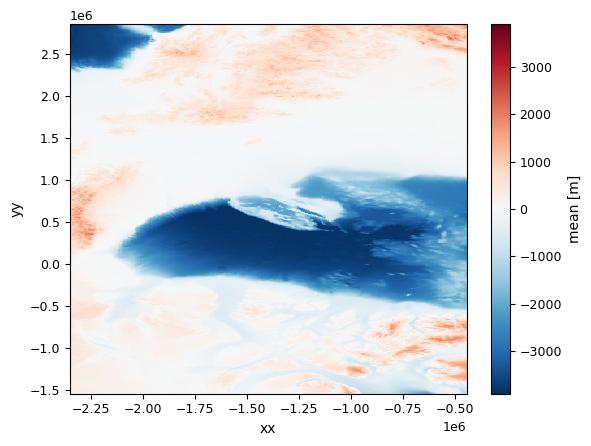

In [22]:
dsb = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/re-gridded/master_625kmASI_V1.nc')
dsb = dsb.sel(xx=slice(-2346875, -446875), yy=slice(-1546875, 2846875))

dsb.avg.plot()

In [23]:
use_depth_ts = {}
use_depth_ts['M1'] = [-36, -26., -16.] #[-39., -28., -22., -16.] [-36., -28., -22., -16.]
use_depth_ts['M2'] = [-162,  -40] #[-162.5,  -39. ,  -31. ,  -26. ,  -20. ] [-162., -143., -126., -109.,  -91.,  -74.,  -57.,  -40.]
use_depth_ts['M3'] = [-252, -194, -134, -52] # [-252., -192., -132.,  -52.] [-259., -196., -136.,  -50.]
use_depth_ts['M4'] = [-247., -186.5, -127.5,  -51]#[-247., -183., -125.,  -44.] # [-250., -190., -130.,  -51.]


list_depth_ts = {}
list_depth_ts['M1'] = [-37.5, -26., -16.]
list_depth_ts['M2'] = [-162.25,  -39.5]
list_depth_ts['M3'] = [-255.5, -194, -134, -51]
list_depth_ts['M4'] = [-248.5, -186.5, -127.5,  -47.5]

use_depth = {}

use_depth['M1'] = np.arange(-40,-1, 2.5)
use_depth['M2'] = np.arange(-154,-49, 4)
use_depth['M3'] = np.arange(-260,-39, 8)
use_depth['M4'] = np.arange(-310,-68, 16)

use_depth['M3']

array([-260, -252, -244, -236, -228, -220, -212, -204, -196, -188, -180,
       -172, -164, -156, -148, -140, -132, -124, -116, -108, -100,  -92,
        -84,  -76,  -68,  -60,  -52,  -44])

In [24]:
from pyproj import Geod
g = Geod(ellps="WGS84")

M = {}
for mooring in ['M1', 'M2', 'M3', 'M4']:  
    M[mooring] = {}
    
    open_years = '2017_2018'
    path = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/'
    with xr.open_dataset(path+f"{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc") as ds:
        M[mooring]['lat'] = ds.lat
        M[mooring]['lon'] = ds.lon

        
# # create false M0 mooring along shelf current
# M['M0'] = {}
# shelf_angle = 145
# # shelf_angle = 165
# shelf_az = 90-shelf_angle
# M['M0']['lon'], M['M0']['lat'], backaz = g.fwd(M['M1']['lon'], M['M1']['lat'], shelf_az, 80000)

# create false M0 mooring along shelf current
M['M0'] = {}
shelf_angle = -125
# shelf_angle = 165
shelf_az = 90-shelf_angle
M['M0']['lon'], M['M0']['lat'], backaz = g.fwd(M['M1']['lon'], M['M1']['lat'], shelf_az, 20000)


# create false M0 mooring along shelf current
M['M5'] = {}
deep_angle = 90
deep_az = 90-deep_angle
M['M5']['lon'], M['M5']['lat'], backaz = g.fwd(M['M4']['lon'], M['M4']['lat'], deep_az, 20000)

up_canyon_angles = {}
up_canyon_angles['M1'] = 145
up_canyon_angles['M2'] = 210
up_canyon_angles['M3'] = 290
up_canyon_angles['M4'] = 270


target_region = dsg.elevation.values >-100

twd_shelf_angles = {}
twd_shelf_lons = {}
twd_shelf_lats = {}

for m in ['M1', 'M2', 'M3', 'M4']:
    lon, lat = M[m]['lon'], M[m]['lat']
    xp, yp = target_proj.transform_point(lon, lat, ccrs.PlateCarree())
    dist = np.sqrt((xe-xp)**2 + (ye-yp)**2)
    shelf_lon = lone[np.where(dist == dist[target_region].min())]
    shelf_lat = late[np.where(dist == dist[target_region].min())]
    twd_shelf_angles[m] = find_direction(lon, lat, shelf_lon, shelf_lat)
    twd_shelf_lons[m] = shelf_lon
    twd_shelf_lats[m] = shelf_lat
    
twd_shelf_angles['M1'] = 145


twd_M1_angles = {}
for ma in [ 'M2', 'M3', 'M4', 'M1']:
    angle = find_angle(M, ma, 'M1')
    if ma == 'M1':
        angle = 145
    twd_M1_angles[ma] = angle
    
twd_nextm_angles = {}
for ma in ['M4', 'M3','M2',  'M1']:
    angle = find_angle(M, ma, f'M{int(ma[1])-1}')
#     if ma == 'M1':
#         angle = 145
    twd_nextm_angles[ma] = angle
    
    
    
spec_angles = {}
spec_angles['M1'] = 145
spec_angles['M2'] = -130
spec_angles['M3'] = -110
spec_angles['M4'] = -145

-123.28948782039072

-120.49695442642957

-108.71021477694507

-90.0

-89.90361640898323

-117.3835393829957

-123.28948782039072

-125.00000000000176



In [25]:


lontracks = np.array([])
lattracks = np.array([])
labels = np.array([])


for ma, mb in zip(['M4','M3', 'M2', 'M1', 'M0'][::-1], ['M5','M4', 'M3', 'M2', 'M1'][::-1], ):
    print(f'{ma}--{mb}')
    if ma == 'M1':
        step_size = 0.5
    else:
        step_size = 1
    coords = find_steps(M[ma], M[mb], step_size = step_size)
    # add nearest elevations
    #------------------------
    # ma
    lon, lat = M[ma]['lon'], M[ma]['lat']
    labels = np.append(labels, ma)
    lontracks = np.append(lontracks, lon)
    lattracks = np.append(lattracks, lat)

    # intermediate
    for lon, lat in coords:
        labels = np.append(labels, None)
        lontracks = np.append(lontracks, lon)
        lattracks = np.append(lattracks, lat)
        
# final mb
lon, lat = M[mb]['lon'], M[mb]['lat']
labels = np.append(labels, mb)
lontracks = np.append(lontracks, lon)
lattracks = np.append(lattracks, lat)

# find depths at each spot
elevations = np.array([])
for lon, lat in zip(lontracks, lattracks):
    weighted_depth, nearest_depth = weighted_mean_depth(dsg, target_proj, xe, ye, lon, lat)
    elevations = np.append(elevations, weighted_depth)
    
    
# find distances along each spot
distances = np.array([0])
for ii in range(len(lontracks)-1):
    dist = find_distance(lontracks[ii], lattracks[ii],
                         lontracks[ii+1], lattracks[ii+1])
    distances = np.append(distances, dist/1000)
distances = np.cumsum(distances)

show_labels = [True if l in ['M1', 'M2', 'M3', 'M4'] else False for l in labels]

M0--M1
20.00 km
17 1-km steps
M1--M2
18.26 km
34 0.5-km steps
M2--M3
17.54 km
15 1-km steps
M3--M4
22.65 km
20 1-km steps
M4--M5
20.00 km
18 1-km steps


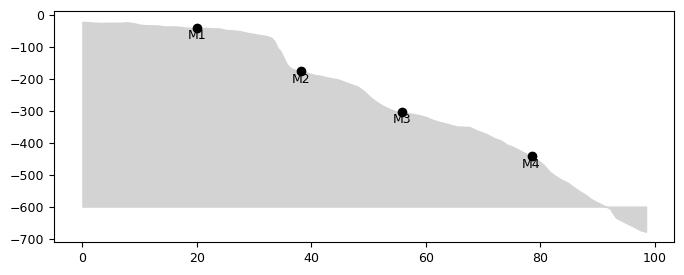

In [26]:
fig, ax = plt.subplots(figsize=(8,3))

ax.fill_between(distances, elevations, -600, color='lightgray')

ax.scatter(distances[show_labels], elevations[show_labels], color='k')

for x, y, t in zip(distances[show_labels], elevations[show_labels], labels[show_labels]):
    ax.text(x, y, f'\n{t}', ha='center', va='center', color='k')


In [28]:
dsc = open_both_years(category = 'ocean_currents')
dst = open_both_years(category = 'tempsalinity')

# mask if non-nan fraction of timeseries falls below...
#===============
msk_b = 0.5
#===============

var = 'v'
# keep1 = np.isnan(dsc[var].sel(time=open_hours)).sum('time')/len(dsc.sel(time=open_hours).time) < msk_b
# keep2 = np.isnan(dsc[var].sel(time=comp_hours)).sum('time')/len(dsc.sel(time=comp_hours).time) < msk_b
# mdsc = dsc.where(keep1&keep2, other=np.nan)

keep = np.isnan(dsc[var]).sum('time')/len(dsc.time) < msk_b
mdsc = dsc.where(keep, other=np.nan)

var = 'Sp'
# keep1 = np.isnan(dst[var].sel(time=open_hours)).sum('time')/len(dst.sel(time=open_hours).time) < msk_b
# keep2 = np.isnan(dst[var].sel(time=comp_hours)).sum('time')/len(dst.sel(time=comp_hours).time) < msk_b
# mdst = dst.where(keep1&keep2, other=np.nan)

keep = np.isnan(dst[var]).sum('time')/len(dst.time) < msk_b
mdst = dst.where(keep, other=np.nan)


all_times = pd.to_datetime(dsc.time.values)


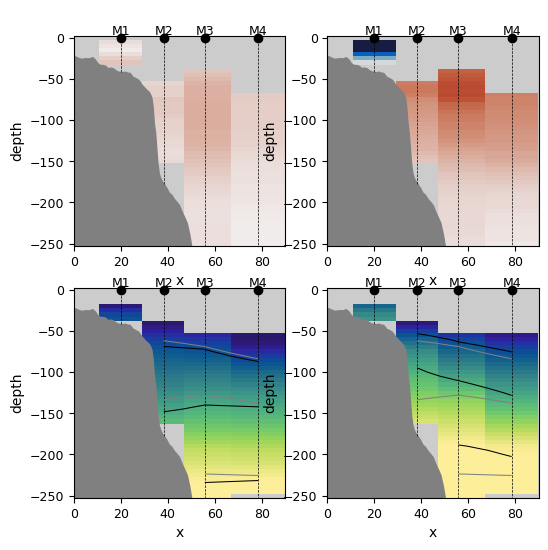

In [29]:

# ds4 = interp_ds(ds4, np.arange(-200,1,5))

fig, AXS = plt.subplots(2,2, figsize=(6,6))

axs = AXS.ravel()
# (ds.Sp.sel(time=open_hours).mean('time')-ds.Sp.sel(time=comp_hours).mean('time')).plot(x='x')

# ((ds.Ct-ds.Tf).sel(time=open_hours).mean('time')-(ds.Ct-ds.Tf).sel(time=comp_hours).mean('time')).plot(x='x')


# ((ds.Sp).sel(time=open_hours).mean('time')-(ds.Sp).sel(time=comp_hours).mean('time')).plot(x='x')



# ((mdst.Sp).sel(time=comp_hours).mean('time')).plot(ax = axs[2], x='x',add_colorbar=False, vmin=31,vmax=34.5, cmap=cmocean.cm.haline)

# ((mdst.Sp).sel(time=open_hours).mean('time')).plot(ax = axs[3], x='x',add_colorbar=False, vmin=31,vmax=34.5, cmap=cmocean.cm.haline)


# ((mdst.sig0-mdst.lowf_sig0).sel(time=comp_hours).mean('time')).plot(ax = axs[2], x='x',add_colorbar=False, vmin=-0.5,vmax=0.5, cmap=cmocean.cm.haline)

# ((mdst.sig0-mdst.lowf_sig0).sel(time=open_hours).mean('time')).plot(ax = axs[3], x='x',add_colorbar=False, vmin=-0.5,vmax=0.5, cmap=cmocean.cm.haline)



comp_data = (mdst.sig0).sel(time=comp_hours)
open_data = (mdst.sig0).sel(time=open_hours)

(comp_data.mean('time')).plot(ax = axs[2], x='x',add_colorbar=False, vmin=25,vmax=27.5, cmap=cmocean.cm.haline)

(open_data.mean('time')).plot(ax = axs[3], x='x',add_colorbar=False, vmin=25,vmax=27.5, cmap=cmocean.cm.haline)


((mdsc.cross).sel(time=comp_hours).mean('time')).plot(ax = axs[0], add_colorbar=False,
                                                           x='x', vmin=-0.2,vmax=0.2, cmap=cmocean.cm.balance)

((mdsc.cross).sel(time=open_hours).mean('time')).plot(ax = axs[1], add_colorbar=False,
                                                           x='x', vmin=-0.2,vmax=0.2, cmap=cmocean.cm.balance)

Y, X = np.meshgrid(mdst.depth.values, mdst.x.values)
sig_vals = [25.5,26.5,27.5]

for sig_val in sig_vals:
    
    for ax, cat in zip([axs[2], axs[3]], [comp_hours, open_hours]):
        ax.contour(X, Y, (mdst.sig0).sel(time=cat).mean('time').values, levels=[sig_val],  
                   colors=['k'], linewidths=[0.75],zorder=100)
        ax.contour(X, Y, (mdst.sig0).mean('time').values, 
                   levels=[sig_val], colors=['gray'], linewidths=[0.75],zorder=100)


for ax in axs:
    ax.patch.set_facecolor([0.8]*3)
    ax.fill_between(distances, elevations, -600, color='gray')
    ax.set_xlim(0,90)
    ax.set_yticks(np.arange(-250,1,50))
    for x, y, t in zip(distances[show_labels], elevations[show_labels], labels[show_labels]):
        ax.scatter(x, 0, color='k', clip_on=False)
        ax.plot([x,x], [y,0], ls='dashed', lw=0.5, color='k', clip_on=True)
        ax.text(x, 0, f'\n{t}', ha='center', va='bottom', color='k', clip_on=False)
        
# axs[1].set_yticklabels([])

#     elevations[show_labels]
# ((ds.v).sel(time=open_hours).mean('time')-(ds.v).sel(time=comp_hours).mean('time')).plot(x='x', vmin=-0.2,vmax=0.2, cmap=cmocean.cm.balance)


In [160]:
# OHT = (dsc.cross*mdst.sig0*(mdst.Ct-mdst.Tf))#.sel(x = mdst.x.values[1])

# OHT.mean('time').plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance)
# # plt.plot(DFDT.sel(time=open_hours).mean('time').plot()

In [839]:
# # sample to grab time info
# #-------------------------
# ds1 = open_and_interp(2017, 'M1', use_depth)
# ds2 = open_and_interp(2018, 'M1', use_depth)
# ds = xr.concat([ds1, ds2], dim="time")


# all_times = pd.to_datetime(ds.time.values)

# all_lengths = np.array([])

# outside_event = np.array([], dtype=bool)


# for date in all_times:
#     date_no_hour = date - timedelta(hours = date.hour)
#     cond = pd.to_datetime(df.time.values) == date_no_hour
#     length = df[cond].length_max.values
    
#     curr_df = df[pd.to_datetime(df.time.values) == date_no_hour]
#     not_before = (curr_df.day_before_event<-7)+(curr_df.day_before_event==-999)
#     not_after = (curr_df.day_after_event>7)+(curr_df.day_after_event==-999)

#     outside_event = np.append(outside_event, ((curr_df.extent==0)&(not_before&not_after)).item())
    
#     # filter for certain events (87 - 105) 96 is Dec event
# #     if (length>0) & (df[cond].sequence.values[0] != 104):
# #         length = np.nan
    
#     all_lengths = np.append(all_lengths, length)
    

In [216]:
# open_cond = (all_lengths > 0)
# comp_cond = (all_lengths == 0)# & outside_event

# event_dates = {}
# event_dates['open'] = all_times[::24][all_lengths[::24]>0]
# event_dates['comp'] = all_times[::24][(all_lengths[::24]==0)&(outside_event[::24])]

# event_dates = {}
# event_dates['open'] = all_times[::24][all_lengths[::24]>0]
# event_dates['comp'] = all_times[::24][(all_lengths[::24]==0)]#&(outside_event[::24])]



In [219]:
len(event_dates['open'])/24

73.0

In [220]:
len(event_dates['comp'])/24

195.0

In [32]:
vecdata = {}

cats = ['tip_x', 'tip_y', 'vec_x', 'vec_y', 'tail_x', 'tail_y',
       'mean_x', 'mean_y', 'varell_x', 'varell_y']
conditions = ['comp', 'open']

for m in ['M1', 'M2', 'M3', 'M4']:
    vecdata[m] = {}
    
    for where in ['ocn', 'ice']:
        vecdata[m][where] = {}
    
        for cond in conditions:
            vecdata[m][where][cond] = {}
            for cat in cats:
                vecdata[m][where][cond][cat] = np.array([])
                
for m in ['M1', 'M2', 'M3', 'M4']:
    
    print(m)
    
    # merge both years
    #------------------------
    ds1 = open_and_interp(2017, m, use_depth)
    ds2 = open_and_interp(2018, m, use_depth)
    ds = xr.concat([ds1, ds2], dim="time")
    
    
#     ds1 = open_and_interp_ice(2017, m)
#     ds2 = open_and_interp_ice(2018, m)
#     ds_ice = xr.concat([ds1, ds2], dim="time")
    
    for cond, times in zip(['comp', 'open'], [comp_hours, open_hours]):
        
        
#         tailsi, tipsi, vecsi = grab_vector_range_ice(ds_ice, condition, daily_means = True)


        if m == 'M1':
            depth_slice = slice(-40,0)
        else:
            depth_slice = slice(-100,0)
            
            
        
#         tailso, tipso, vecso = grab_vector_range(ds, condition, depth_range = depth_slice, daily_means = True)
        tailso, tipso, vecso = grab_vector_range_v1(ds.sel(time=times), depth_range = depth_slice)
        
#         for where, tails, tips, vecs in zip(['ocn', 'ice'], [tailso, tailsi], 
#                                             [tipso, tipsi], [vecso, vecsi]):

        for where, tails, tips, vecs in zip(['ocn', ], [tailso,], 
                                            [tipso,], [vecso,]):

            cdata = vecdata[m][where][cond]

            # grab tips
            cdata['tip_x'] = np.append(cdata['tip_x'], np.array([tip[0] for tip in tips]))
            cdata['tip_y'] = np.append(cdata['tip_y'], np.array([tip[1] for tip in tips]))

            # grab tails
            cdata['tail_x'] = np.nanmean(np.array([tail[0] for tail in tails]))
            cdata['tail_y'] = np.nanmean(np.array([tail[1] for tail in tails]))


            # grab vectors
            cdata['vec_x'] = np.append(cdata['vec_x'], np.array([vec[0].magnitude for vec in vecs]))
            cdata['vec_y'] = np.append(cdata['vec_y'], np.array([vec[1].magnitude for vec in vecs]))


            x = cdata['vec_x']
            y = cdata['vec_y']

            cdata['mean_x'] = np.nanmean(cdata['vec_x'])
            cdata['mean_y'] = np.nanmean(cdata['vec_y'])

            xp = x[np.isfinite(x)&np.isfinite(y)]
            yp = y[np.isfinite(x)&np.isfinite(y)]

            # find variance ellipses
            varell = tanalyze.variance_ellipses(xp,yp)
            xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
            ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))

            cdata['varell_x'] = varell['xe']
            cdata['varell_y'] = varell['ye']



M1
M2
M3
M4


### Open SIC data

In [37]:

# RES = '1000ma2'
# crop = [2100, 3400, 340, 800]
# sic_key = 'sic_merged'

# RES = '6250'
# # crop=[500, 1300, 100, 500]
# crop=[700, 1150, 200, 400]
# sic_key = 'sic'

RES = '3125'
crop=[1500, 2050, 480, 700]
sic_key = 'sic'

dsic = unisic.open_local_file(datetime(2020,1,1), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)

open_thresh=10

map_sic = {}
for key in event_dates.keys():

# for key in ['open']:

    print(key)
    map_sic[key] = unisic.calc_meansic_openfreq(pd.to_datetime(event_dates[key]), crop=crop, nan_frac = 0.05,
                                            open_thresh=open_thresh, res=RES, hem='n', sic_key = sic_key, 
                                            main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                            coordinates=False, area=False, quiet=True)

open
comp


In [ ]:

# map_proj = ccrs.NorthPolarStereo(central_longitude=-140)

# drift_map = {}

# for key in event_dates.keys():
    
# # for key in ['open']:
#     print(key)
#     drift_map[key] = fn.drift_map_over_time(event_dates[key], map_proj, crop = True, include_times = True)

In [ ]:

# map_proj = ccrs.NorthPolarStereo(central_longitude=-140)

# wind_map = {}

# for key in event_dates.keys():
    
# # for key in ['open']:
#     print(key)
#     wind_map[key] = fn.wind_map_over_time(event_dates[key], map_proj, 
#                                           era_lat = slice(74, 68), era_lon = slice(-158,-125), include_times = False)

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:395: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


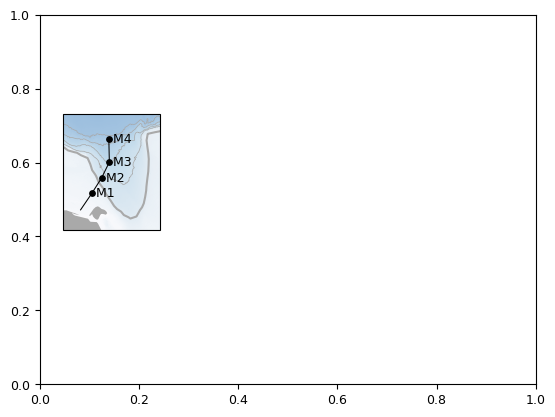

In [35]:


BBOX = (-0.025, 1.075, 1, 1)

colors = [
    (-3000, (0.35, 0.45, 0.65)),  # lighter deep blue
    (-2000, (0.55, 0.70, 0.85)),  # light blue
    (-1000,  (0.75, 0.85, 0.92)),  # very light blue
    (-400,   (0.88, 0.92, 0.95)),  # pale blue-gray
    (-100,     (0.98, 0.98, 0.99))   # near-white at sea level
]
# Normalize depth values to 0–1
depths, rgb = zip(*colors)
depths = np.array(depths)
rgb = np.array(rgb)
norm_depths = (depths - depths.min()) / (depths.max() - depths.min())

# Create colormap with nonuniform spacing
cmap = LinearSegmentedColormap.from_list("stretched_near_surface", list(zip(norm_depths, rgb)))

    
def show_inset_map2(ax, width="100%", height="50%", bbox_to_anchor=(1.0, 0.025, 1, 1)):
    
    # Create inset axes
    #---------------------------------------
    map_proj = ccrs.NorthPolarStereo(central_longitude=-140)
    axins = inset_axes(ax, width=width, height=height, loc="lower left",
                        bbox_to_anchor=bbox_to_anchor,
                       bbox_transform=ax.transAxes,
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(map_projection=map_proj))
#     axins.set_ylim(-2320000,-2180000)
#     axins.set_xlim(-160000,92000)

#     axins.set_ylim(-2320000,-2170000)
#     axins.set_xlim(-160000,92000)

    axins.set_ylim(-2320000,-2190000)
    axins.set_xlim(-120000,92000)
    
    geomap.land(axins, scale = '10m', color=[0.55]*3, alpha=1, fill_dateline_gap = False, zorder=2)
    axins.patch.set_facecolor([0.85]*3)
    
    
    sp = 3
    axins.contour(dsg.lon.values[::sp,], dsg.lat.values[::sp,], dsg.elevation[::sp,::sp], 
                      levels=[-500,-400,-300,-200,], colors=['darkgray'], linewidths=0.5, linestyles='solid',
                      zorder=95, transform=ccrs.PlateCarree())
    
    axins.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.5],linestyles=['solid'], transform=dsic['proj'])

    
    # axins.add_feature(cartopy.feature.COASTLINE)

    return axins




def show_inset_map(ax):
    
    # Create inset axes
    #---------------------------------------
    map_proj = ccrs.NorthPolarStereo(central_longitude=-140)
    axins = inset_axes(ax, width="35%", height="35%", loc="lower left",
                        bbox_to_anchor=(-0.025, 0.4, 0.9, 0.9),
                       bbox_transform=ax.transAxes,
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(map_projection=map_proj))
    axins.set_ylim(-2320000,-2200000)
    axins.set_xlim(0,100000)
    geomap.land(axins, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)
    # axins.add_feature(cartopy.feature.COASTLINE)

    for m in ['M1', 'M2','M3', 'M4']:
        axins.scatter(M[m]['lon'], M[m]['lat'], c='k', s = 15, transform=ccrs.PlateCarree(), zorder=100)
        axins.text(M[m]['lon'], M[m]['lat'], f' {m}', c='k', ha='left', va='center', transform=ccrs.PlateCarree(), zorder=100)
    for m in ['M0','M1', 'M2','M3', ]: 
        axins.plot([M[m]['lon'], M[f'M{int(m[1])+1}']['lon']], 
                   [M[m]['lat'], M[f'M{int(m[1])+1}']['lat']],  c='k', 
                   lw=0.75, ls='solid', transform=ccrs.PlateCarree(), zorder=100)
        
        
#     startlon, startlat = -139.1, 69.6
#     endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
#     axins.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
#             c=[0.3,0.3,0.3], lw=1.5, zorder=98, ls='dashed')

#     use_cmap = cmocean.tools.crop_by_percent(cmocean.cm.gray, 40, which='min', N=None)
    # axins.pcolormesh(dsg.lon.values, dsg.lat.values, depth_gradient, 
    #               vmin=-1, vmax=12, cmap=use_cmap, zorder=-1, transform=ccrs.PlateCarree())

    norm = TwoSlopeNorm(vmin=-3000, vcenter=-500, vmax=0)
    axins.pcolormesh(dsg.lon.values, dsg.lat.values, dsg.elevation, 
                  cmap=cmap, norm=norm, zorder=-1, transform=ccrs.PlateCarree())
    
    axins.contour(dsg.lon.values, dsg.lat.values, dsg.elevation, 
                  levels=[-500,-400,-300,-200,], colors=['darkgray'], linewidths=0.5, linestyles='solid',
                  zorder=-1, transform=ccrs.PlateCarree())
    axins.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.5],linestyles=['solid'], transform=dsic['proj'])

fig, ax = plt.subplots()
inax0 = show_inset_map(ax)


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:395: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:395: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)
/opt/an

Text(0, 1.1, 'MCP event')

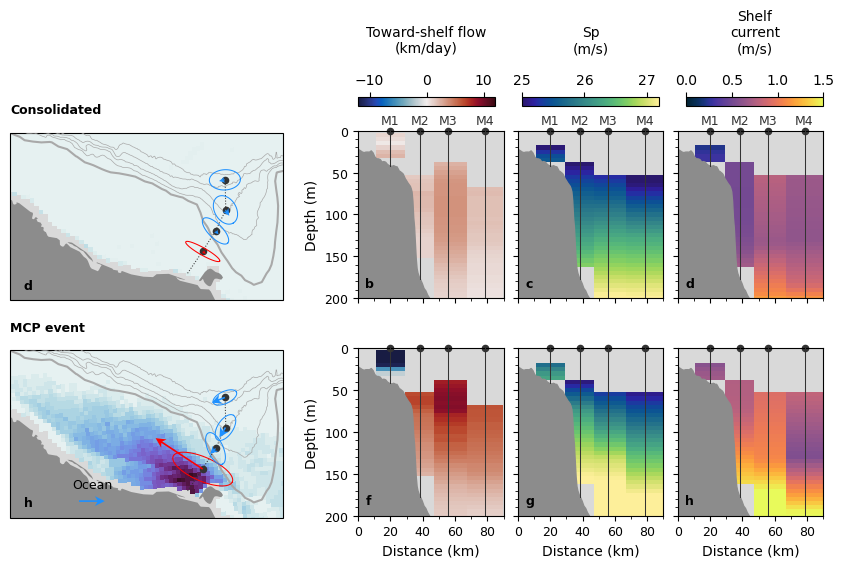

In [38]:
%matplotlib inline

from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda val, pos: f"{abs(val):.0f}")


# fig, ax = plt.subplots(figsize=(6,3.5))

fig, AXS = plt.subplots(2,3,figsize=(6,5))

axs = AXS.ravel()





moocolor = [0.2]*3



# plot the cross-shelf flow
#-------------------------

for ax in axs:
    ax.patch.set_facecolor([0.85]*3)
    ax.fill_between(distances, elevations, -600, color=[0.55]*3)

    for x, y, t in zip(distances[show_labels], elevations[show_labels], labels[show_labels]):
        ax.scatter(x, 0, color=moocolor, s=20, clip_on=False)
        ax.plot([x,x], [y,0], c=moocolor, lw=0.75,ls='solid', zorder=100)
        if ax in [axs[0], axs[1], axs[2]]:
            ax.text(x, 0+5, f'{t}', ha='center', va='bottom', color=moocolor, clip_on=False)
    
    
# ((mdst.Sp).sel(time=comp_hours).mean('time')).plot(ax = axs[1], add_colorbar=False,
#                                                            x='x', vmin=31.5,vmax=34, cmap=cmocean.cm.haline, zorder=-1)
# ((mdst.Sp).sel(time=open_hours).mean('time')).plot(ax = axs[4], add_colorbar=False,
#                                                            x='x', vmin=31.5,vmax=34, cmap=cmocean.cm.haline, zorder=-1)



((mdsc.cross*units('m/s').to('km/day')).sel(time=comp_hours).mean('time')).plot(ax = axs[0], add_colorbar=False,
                                                           x='x', vmin=-12,vmax=12, cmap=cmocean.cm.balance, zorder=-1)
meshC = ((mdsc.cross*units('m/s').to('km/day')).sel(time=open_hours).mean('time')).plot(ax = axs[3], add_colorbar=False,
                                                           x='x', vmin=-12,vmax=12, cmap=cmocean.cm.balance, zorder=-1)

plotter.add_colorbar(fig, axs[0], [meshC], cb_placement='top', cb_orientation='auto',
                     cb_width='auto', cb_length_fraction=[0, 1], cb_pad=0.05, cb_ticks='auto', 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Toward-shelf flow\n(km/day)',#'Days\nfrom\nDec. 1',
                     labelpad=15, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=10, draw_edges=False, edge_params=['k', 2])


((mdst.sig0).sel(time=comp_hours).mean('time')).plot(ax = axs[1], add_colorbar=False,
                                                           x='x', vmin=25,vmax=27.2, cmap=cmocean.cm.haline, zorder=-1)
meshS = ((mdst.sig0).sel(time=open_hours).mean('time')).plot(ax = axs[4], add_colorbar=False,
                                                           x='x', vmin=25,vmax=27.2, cmap=cmocean.cm.haline, zorder=-1)

# ((mdst.Sp).sel(time=comp_hours).mean('time')).plot(ax = axs[1], add_colorbar=False,
#                                                            x='x', vmin=31,vmax=34, cmap=cmocean.cm.haline, zorder=-1)
# meshS = ((mdst.Sp).sel(time=open_hours).mean('time')).plot(ax = axs[4], add_colorbar=False,
#                                                            x='x', vmin=31,vmax=34, cmap=cmocean.cm.haline, zorder=-1)

plotter.add_colorbar(fig, axs[1], [meshS], cb_placement='top', cb_orientation='auto',
                     cb_width='auto', cb_length_fraction=[0, 1], cb_pad=0.05, cb_ticks='auto', 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Sp\n(m/s)',#'Days\nfrom\nDec. 1',
                     labelpad=15, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=10, draw_edges=False, edge_params=['k', 2])
    
((mdst.Ct-mdst.Tf).sel(time=comp_hours).mean('time')).plot(ax = axs[2], add_colorbar=False,
                                                           x='x', vmin=0,vmax=1.5, cmap=cmocean.cm.thermal, zorder=-1)
meshT = ((mdst.Ct-mdst.Tf).sel(time=open_hours).mean('time')).plot(ax = axs[5], add_colorbar=False,
                                                           x='x', vmin=0,vmax=1.5, cmap=cmocean.cm.thermal, zorder=-1)


plotter.add_colorbar(fig, axs[2], [meshT], cb_placement='top', cb_orientation='auto',
                     cb_width='auto', cb_length_fraction=[0, 1], cb_pad=0.05, cb_ticks='auto', 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Shelf\ncurrent\n(m/s)',#'Days\nfrom\nDec. 1',
                     labelpad=15, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=10, draw_edges=False, edge_params=['k', 2])


# (((mdst.sig0)*(mdst.Ct-mdst.Tf)).sel(time=comp_hours).mean('time')).plot(ax = axs[2], add_colorbar=False,
#                                                            x='x', vmin=0,vmax=50, cmap=cmocean.cm.thermal, zorder=-1)
# (((mdst.sig0)*(mdst.Ct-mdst.Tf)).sel(time=open_hours).mean('time')).plot(ax = axs[5], add_colorbar=False,
#                                                            x='x', vmin=0,vmax=50, cmap=cmocean.cm.thermal, zorder=-1)




# show_inset_map(axs[0])

# plot top-down views
#-------------------------------------------------------
BBOX = (-2.75, -0.05, 1, 1)

inax0 = show_inset_map2(axs[0],  width="250%",height="100%", bbox_to_anchor=BBOX)
inax1 = show_inset_map2(axs[3], width="250%",height="100%", bbox_to_anchor=BBOX)


aw = 0.006

for group, color, ax in zip(['comp','open'], ['r', 'r'], [inax0, inax1]):

#     sp = 1
#     key = group
#     u1 = 1*np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
#     v1 = 1*np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
#     Q = ax.quiver(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], u1[::sp,::sp], v1[::sp,::sp], 
#               angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
#               scale=1, width=0.0035, headwidth=5,headlength=5, headaxislength=5, 
#                   color=[0.35,0.35,0.35], pivot='tail', zorder=98)

#     sp1, sp2 = 1,4
#     key = group
#     u1 = 0.03*wind_map[key]['u10']*units('m/s').to('m/day').magnitude
#     v1 = 0.03*wind_map[key]['v10']*units('m/s').to('m/day').magnitude
#     Q = ax.quiver(wind_map[key]['lon'][::sp1,::sp2], 
#                   wind_map[key]['lat'][::sp1,::sp2], u1[::sp1,::sp2], v1[::sp1,::sp2], 
#               angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
#               scale=1, width=0.0035, headwidth=5,headlength=5, headaxislength=5, 
#                   color=[0.65]*3, pivot='tail', zorder=5)

    
    for m, color in zip(['M1', 'M2','M3', 'M4'], ['r', 'dodgerblue', 'dodgerblue', 'dodgerblue']):
        cdata = vecdata[m]['ocn'][group]

        SCALE = 1
        Qo = ax.quiver(cdata['tail_x'], cdata['tail_y'], 
                  cdata['mean_x'], cdata['mean_y'], 
                  angles='xy', scale_units='xy', scale=SCALE, color=color, width=aw, 
                  headwidth=6, headlength = 6, zorder=100)
        
        ax.plot((1/SCALE)*cdata['varell_x']+cdata['tail_x'], 
                (1/SCALE)*cdata['varell_y']+cdata['tail_y'], c=color, zorder=99, lw=0.75, alpha=1)
        
    for m in ['M0','M1', 'M2','M3', ]: 
        ax.plot([M[m]['lon'], M[f'M{int(m[1])+1}']['lon']], 
                   [M[m]['lat'], M[f'M{int(m[1])+1}']['lat']],  c=moocolor, 
                   lw=0.75, ls='dotted', transform=ccrs.PlateCarree(), zorder=98)

        
# qk = ax.quiverkey(Q, X=0.175, Y=0.1, U=20*1000, label='Ice', labelpos='N', coordinates='axes')
qk = ax.quiverkey(Qo, X=0.3, Y=0.1, U=20*1000, label='Ocean', labelpos='N', coordinates='axes')



for ax in axs:
    kwargs = {'width' : 5, 'color':'gray', 'head_length':5, 'length_includes_head':True}
#     ax.axvline(distances[labels=='M1'], ls='dashed', c='k', lw=0.5)
    ax.set_xlabel('Distance (km)')
    
    # ax.set_xlim(0,145)
    # ax.set_ylim(-460,0)

    # yyy = -440
    # ax.arrow(135, yyy, -50, 0, **kwargs)
    # ax.text(110, yyy+20, 'Toward-shelf', ha='center', weight='bold', color='gray')

    # ax.arrow(75, yyy, -65, 0, **kwargs)
    # ax.text(40, yyy+20, 'Along-shelf', ha='center', weight='bold', color='gray')

    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ax.yaxis.set_minor_locator(MultipleLocator(10))

    ax.set_xlim(0,90)
    ax.set_ylim(-200,0)
    
    ax.yaxis.set_major_formatter(formatter)  # convert depth to positive values
    
    
for ax in [axs[1],axs[2],axs[4], axs[5]]:
    ax.set_yticklabels([])
    ax.set_ylabel("")
    
for ax in [axs[0],axs[1],axs[2]]:
    ax.set_xticklabels([])
    ax.set_xlabel("")
    
for ax in [axs[0],axs[3]]:
    ax.set_ylabel('Depth (m)')
    
    
for ax, lab in zip(axs, ['b', 'c', 'd', 'f', 'g', 'h']):
    ax.text(0.05,0.05,lab, weight='bold', ha='left', va='bottom',clip_on=False, transform=ax.transAxes)
for ax, lab, key in zip([inax0, inax1], ['d', 'h'], [ 'comp', 'open']):
    ax.text(0.05,0.05,lab, weight='bold', ha='left', va='bottom',clip_on=False, transform=ax.transAxes)

    cmesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
                  vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])

#     cmesh = ax.contourf(map_sic[key]['xx'], map_sic[key]['yy'], 100*map_sic[key]['open_freq'], 
#                   vmin=0, vmax=50, levels=np.arange(0,50,2.5), cmap=cmocean.cm.dense, transform=dsic['proj'])


    for m in ['M1', 'M2','M3', 'M4']:
        ax.scatter(M[m]['lon'], M[m]['lat'], c=moocolor, s = 20, transform=ccrs.PlateCarree(), zorder=95)
        
        
    
# axs[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.1, hspace=0.3)




ax = inax0
ax.text(0,1.1,'Consolidated', weight='bold', ha='left', va='bottom',clip_on=False, transform=ax.transAxes)

ax = inax1
ax.text(0,1.1,'MCP event', weight='bold', ha='left', va='bottom',clip_on=False, transform=ax.transAxes)


In [215]:
(90-123)+360

327

# Old plot versions

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/matplotlib/cbook.py:1699: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.isfinite(val)


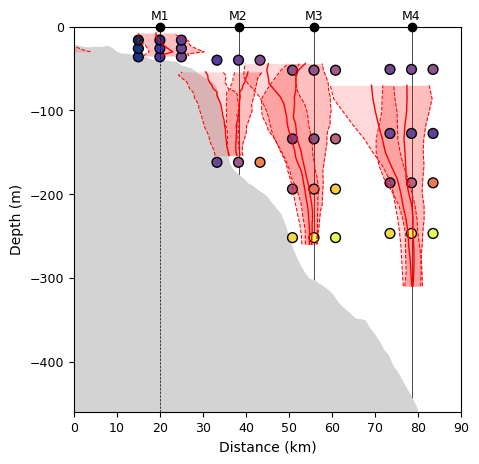

In [833]:
%matplotlib inline

# fig, ax = plt.subplots(figsize=(6,3.5))

fig, ax = plt.subplots(figsize=(5,5))

ax.fill_between(distances, elevations, -600, color='lightgray')


for x, y, t in zip(distances[show_labels], elevations[show_labels], labels[show_labels]):
    ax.scatter(x, 0, color='k', clip_on=False)
    ax.axvline(x, c='k', lw=0.5, zorder=-1)
    ax.text(x, 0+5, f'{t}', ha='center', va='bottom', color='k', clip_on=False)

    
for ma, scale in zip(['M1', 'M2','M3', 'M4'],
                     [1,1,1,1]):


    mb = f'M{int(ma[1])-1}'


    # merge both years
    #------------------------
    ds1 = open_and_interp(2017, ma, use_depth)
    ds2 = open_and_interp(2018, ma, use_depth)
    ds = xr.concat([ds1, ds2], dim="time")

    # find comp along theta
    #------------------------
    #================================
#     angle = twd_M1_angles[ma]
    angle = spec_angles[ma]

#     angle = 145
#     angle = -125 # cross-polynya axis
    #================================
    ds['uc'] = vectors.comp_along_theta(ds.u, ds.v, angle*units('degree'))
    ds['uc_km'] = ds.uc * units('m/s').to('km/day')

    
    # if you want to explore other times outside 
    # of the window - you can use this
    other_times = np.array([], dtype=np.datetime64)
    for time in all_times[open_cond]:
        time_before = time - timedelta(hours=144)
        if time_before not in all_times[open_cond]:
            other_times = np.append(other_times, time_before)
        
    open_uc = ds.uc_km.sel(time = all_times[open_cond])
    comp_uc = ds.uc_km.sel(time = all_times[comp_cond])
    
    
    # find fraction of good points and average flows
    #------------------------
    good_frac = np.isfinite(ds.uc_km).sum('time') / len(ds.time)
    good_frac_open = np.isfinite(open_uc).sum('time') / len(open_uc.time)
    good_frac_comp = np.isfinite(comp_uc).sum('time') / len(comp_uc.time)

    #============
    thresh = 0.5
    #============

    open_depths = open_uc.depth.values[good_frac_open>thresh]
    comp_depths = comp_uc.depth.values[good_frac_comp>thresh]
    
    # by means and std dec
    #------------------
#     ctr_open_flow = -open_uc.mean('time')[good_frac_open>thresh].values
#     ctr_comp_flow = -comp_uc.mean('time')[good_frac_comp>thresh].values

#     open_flow_std = -open_uc.std('time')[good_frac_open>thresh].values
#     comp_flow_std = -comp_uc.std('time')[good_frac_comp>thresh].values
    
#     lft_open_flow = ctr_open_flow - open_flow_std
#     rgt_open_flow = ctr_open_flow + open_flow_std
    
#     lft_comp_flow = ctr_comp_flow - comp_flow_std
#     rgt_comp_flow = ctr_comp_flow + comp_flow_std


    # by percentiles
    #------------------
    ctr_open_flow = -open_uc.quantile(0.5, 'time')[good_frac_open>thresh].values
    lft_open_flow = -open_uc.quantile(0.25, 'time')[good_frac_open>thresh].values
    rgt_open_flow = -open_uc.quantile(0.75, 'time')[good_frac_open>thresh].values
    
    ctr_comp_flow = -comp_uc.quantile(0.5, 'time')[good_frac_comp>thresh].values
    lft_comp_flow = -comp_uc.quantile(0.25,'time')[good_frac_comp>thresh].values
    rgt_comp_flow = -comp_uc.quantile(0.75,'time')[good_frac_comp>thresh].values


    # do the plotting
    #-------------------------
    X = distances[labels==ma]

    for mn, left, right, depths, color, alpha in zip([ctr_comp_flow, ctr_open_flow],
                                             [lft_comp_flow, lft_open_flow],
                                              [rgt_comp_flow, rgt_open_flow],
                                             [comp_depths, open_depths],
                                             ['r', 'r'], [0.25,0.15]):

        ax.plot( scale * (mn) + X, depths, c=color)

        ax.fill_betweenx(depths,
                         scale * (left) + X,
                         scale * (right) + X,  color=color, alpha=alpha, lw=0)
    
        ax.plot( scale * (left) + X, depths, c=color, lw=0.75, ls='dashed')
        ax.plot( scale * (right) + X, depths, c=color, lw=0.75, ls='dashed')
        
        
        
        
    
    ds1 = open_and_interp_t_s(2017, ma, use_depth_ts)
    ds2 = open_and_interp_t_s(2018, ma, use_depth_ts)
    ds_ts = xr.concat([ds1, ds2], dim="time")
    
    ax.scatter(np.full(len(ds_ts.depth), X), 
           ds_ts.dT.mean('time').depth,
           c=ds_ts.dT.mean('time'), vmin=0, vmax=2, cmap=cmocean.cm.thermal, 
          edgecolor='k', s=50)

    open_dt_ts = ds_ts.dT.sel(time = all_times[open_cond])
    ax.scatter(np.full(len(ds_ts.depth), X+5), 
           open_dt_ts.mean('time').depth,
           c=open_dt_ts.mean('time'), vmin=0, vmax=2, cmap=cmocean.cm.thermal, 
          edgecolor='k', s=50)

    
    comp_dt_ts = ds_ts.dT.sel(time = all_times[comp_cond])
    ax.scatter(np.full(len(ds_ts.depth), X-5), 
           comp_dt_ts.mean('time').depth,
           c=comp_dt_ts.mean('time'), vmin=0, vmax=2, cmap=cmocean.cm.thermal, 
          edgecolor='k', s=50)

    
    
#     open_dt_ts = ds_ts.sig0.sel(time = all_times[open_cond])
#     comp_dt_ts = ds_ts.sig0.sel(time = all_times[comp_cond])

#     scale = -0.75
#     mn = open_dt_ts.mean('time')
#     ax.plot( scale * (mn) + X, ds_ts.depth, c='r')
    
#     mn = comp_dt_ts.mean('time')
#     ax.plot( scale * (mn) + X, ds_ts.depth, c='dodgerblue')
    
        


kwargs = {'width' : 5, 'color':'gray', 'head_length':5, 'length_includes_head':True}
ax.axvline(distances[labels=='M1'], ls='dashed', c='k', lw=0.5)
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (m)')

# ax.set_xlim(0,145)
# ax.set_ylim(-460,0)

# yyy = -440
# ax.arrow(135, yyy, -50, 0, **kwargs)
# ax.text(110, yyy+20, 'Toward-shelf', ha='center', weight='bold', color='gray')

# ax.arrow(75, yyy, -65, 0, **kwargs)
# ax.text(40, yyy+20, 'Along-shelf', ha='center', weight='bold', color='gray')

ax.set_xlim(0,90)
ax.set_ylim(-460,0)

yyy = -440
# ax.arrow(135, yyy, -50, 0, **kwargs)
# ax.text(110, yyy+20, 'Toward-shelf', ha='center', weight='bold', color='gray')

# ax.arrow(75, yyy, -65, 0, **kwargs)
# ax.text(40, yyy+20, 'Along-shelf', ha='center', weight='bold', color='gray')







# Create inset axes
#---------------------------------------
# map_proj = ccrs.NorthPolarStereo(central_longitude=-140)
# axins = inset_axes(ax, width="40%", height="45%", loc="lower left",
#                     bbox_to_anchor=(0.05, 0.2, 1, 1),
#                    bbox_transform=ax.transAxes,
#                    axes_class=cartopy.mpl.geoaxes.GeoAxes, 
#                    axes_kwargs=dict(map_projection=map_proj))
# axins.set_ylim(-2315000,-2200000)
# axins.set_xlim(-60000,100000)
# geomap.land(axins, scale = '10m', color='gray', alpha=1, fill_dateline_gap = False, zorder=2)
# # axins.add_feature(cartopy.feature.COASTLINE)

# for m in ['M1', 'M2','M3', 'M4']:
#     axins.scatter(M[m]['lon'], M[m]['lat'], c='k', s = 15, transform=ccrs.PlateCarree(), zorder=100)
#     axins.text(M[m]['lon'], M[m]['lat'], f' {m}', c='k', ha='left', va='center', transform=ccrs.PlateCarree(), zorder=100)
# for m in ['M0','M1', 'M2','M3', ]: 
#     axins.plot([M[m]['lon'], M[f'M{int(m[1])+1}']['lon']], 
#                [M[m]['lat'], M[f'M{int(m[1])+1}']['lat']],  c='k', 
#                lw=1, ls='dashed', transform=ccrs.PlateCarree(), zorder=100)

# use_cmap = cmocean.tools.crop_by_percent(cmocean.cm.gray, 25, which='min', N=None)
# # axins.pcolormesh(dsg.lon.values, dsg.lat.values, depth_gradient, 
# #               vmin=-1, vmax=12, cmap=use_cmap, zorder=-1, transform=ccrs.PlateCarree())

# axins.pcolormesh(dsg.lon.values, dsg.lat.values, dsg.elevation, 
#               vmin=-600, vmax=10, cmap=use_cmap, zorder=-1, transform=ccrs.PlateCarree())
# axins.contour(dsg.lon.values, dsg.lat.values, dsg.elevation, 
#               levels=[-500,-400,-300,-200,-100], colors=['gray'], linewidths=0.5, linestyles='solid',
#               zorder=-1, transform=ccrs.PlateCarree())


# fig.savefig('../figures/results/canyon_flow.png', dpi=400, bbox_inches='tight', pad_inches=0)




/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:395: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


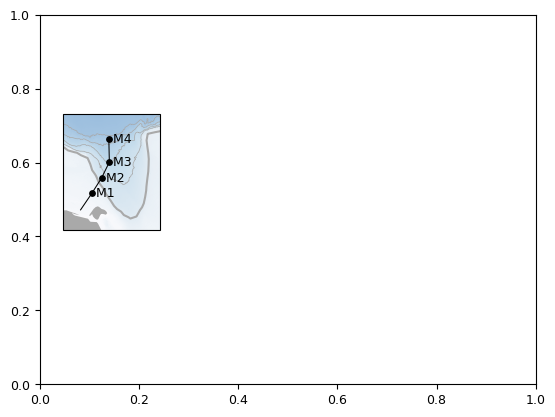

In [193]:
fig, ax = plt.subplots()

inax0 = show_inset_map(ax)



NameError: name 'show_inset_map2' is not defined

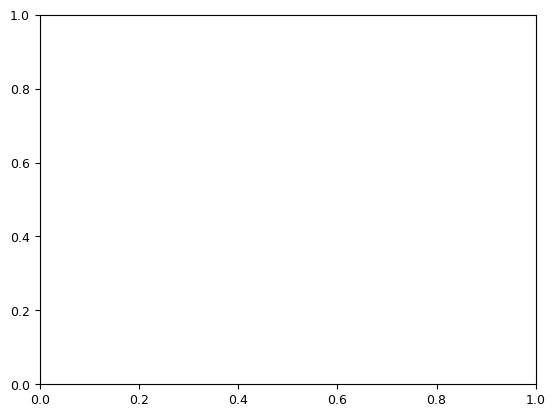

In [186]:
fig, ax = plt.subplots()

inax0 = show_inset_map2(ax, width="100%", height="60%", bbox_to_anchor=BBOX)

ax = inax0

key = 'comp'

sp = 1
u1 = 1*np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
v1 = 1*np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
Q = ax.quiver(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], u1[::sp,::sp], v1[::sp,::sp], 
          angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
          scale=1, width=0.0035, headwidth=4,headlength=4, headaxislength=4, 
              color=[0.25,0.25,0.25], pivot='tail', zorder=100)

geomap.scalebar(ax, loc=(0.05, 0.1), steps=[10,20,50],unit='km', 
                label=None, colors=['k', 'w'], edgecolor=None, textsize=8, lw=1, 
                bar_width=0.035, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=True)

# ax.text(0.85,0.415,'100 m',size = FS-2, color='gray', rotation=35,
#         transform=ax.transAxes)

# qk = ax.quiverkey(Q, X=0.1, Y=0.4, U=10*1000, label='Ice', labelpos='N', coordinates='axes')
qk = ax.quiverkey(Q, X=0.125, Y=0.3, U=10*1000, label='Ocean', labelpos='N', coordinates='axes')
# qk = ax.quiverkey(Q, X=0.125, Y=0.15, U=10*1000, label='$\mathrm{10\;km\;d^{-1}}$\nIce drift', labelpos='N', coordinates='axes')

### Compile data

In [814]:

mdat = {}

for ma, scale in zip(['M1', 'M2','M3', 'M4'],
                     [1,1,1,1]):


    mb = f'M{int(ma[1])-1}'


    # merge both years
    #------------------------
    ds1 = open_and_interp(2017, ma, use_depth)
    ds2 = open_and_interp(2018, ma, use_depth)
    ds = xr.concat([ds1, ds2], dim="time")

    # find comp along theta
    #------------------------
    #================================
#     angle = twd_M1_angles[ma]
    angle = twd_nextm_angles[ma]

#     angle = 145
#     angle = -125 # cross-polynya axis
    #================================
    ds['uc'] = vectors.comp_along_theta(ds.u, ds.v, angle*units('degree'))
    ds['uc_km'] = ds.uc * units('m/s').to('km/day')


    open_cond = (all_lengths > 0) 
    comp_cond = (all_lengths == 0) 
    
    # if you want to explore other times outside 
    # of the window - you can use this
    other_times = np.array([], dtype=np.datetime64)
    for time in all_times[open_cond]:
        time_before = time - timedelta(hours=144)
        if time_before not in all_times[open_cond]:
            other_times = np.append(other_times, time_before)
        
    open_uc = ds.uc_km.sel(time = all_times[open_cond])
    comp_uc = ds.uc_km.sel(time = all_times[comp_cond])
    
    
    # find fraction of good points and average flows
    #------------------------
    good_frac = np.isfinite(ds.uc_km).sum('time') / len(ds.time)
    good_frac_open = np.isfinite(open_uc).sum('time') / len(open_uc.time)
    good_frac_comp = np.isfinite(comp_uc).sum('time') / len(comp_uc.time)

    #============
    thresh = 0.5
    #============

    mdat[ma] = {}
    mdat[ma]['open'] = {}
    mdat[ma]['comp'] = {}
    
    mdat[ma]['open']['depth'] = open_uc.depth.values[good_frac_open>thresh]
    mdat[ma]['comp']['depth'] = comp_uc.depth.values[good_frac_comp>thresh]

    # by percentiles
    #------------------
    mdat[ma]['open']['ctr'] = -open_uc.quantile(0.5, 'time')[good_frac_open>thresh].values
    mdat[ma]['open']['lft'] = -open_uc.quantile(0.25, 'time')[good_frac_open>thresh].values
    mdat[ma]['open']['rgt'] = -open_uc.quantile(0.75, 'time')[good_frac_open>thresh].values
    mdat[ma]['open']['l_max']  = -open_uc.quantile(0.1, 'time')[good_frac_open>thresh].values
    mdat[ma]['open']['r_max']  = -open_uc.quantile(0.9, 'time')[good_frac_open>thresh].values
    
    mdat[ma]['comp']['ctr'] = -comp_uc.quantile(0.5, 'time')[good_frac_comp>thresh].values
    mdat[ma]['comp']['lft'] = -comp_uc.quantile(0.25,'time')[good_frac_comp>thresh].values
    mdat[ma]['comp']['rgt'] = -comp_uc.quantile(0.75,'time')[good_frac_comp>thresh].values
    mdat[ma]['comp']['l_max'] = -comp_uc.quantile(0.1,'time')[good_frac_comp>thresh].values
    mdat[ma]['comp']['r_max'] = -comp_uc.quantile(0.9,'time')[good_frac_comp>thresh].values

    
    # open temps
    #----------------------------------------------
    ds1 = open_and_interp_t_s(2017, ma, use_depth_ts)
    ds2 = open_and_interp_t_s(2018, ma, use_depth_ts)
    ds_ts = xr.concat([ds1, ds2], dim="time")
    
    open_dt_ts = ds_ts.dT.sel(time = all_times[open_cond])
    comp_dt_ts = ds_ts.dT.sel(time = all_times[comp_cond])

#     open_temp_mn = open_dt_ts.mean('time')
#     comp_temp_mn = comp_dt_ts.mean('time')

    mdat[ma]['open']['Tmn'] = open_dt_ts.quantile(0.5,'time').values
    mdat[ma]['comp']['Tmn'] = comp_dt_ts.quantile(0.5,'time').values
    
#     lft_comp_t = comp_dt_ts.quantile(0.25,'time').values
#     rgt_comp_t = comp_dt_ts.quantile(0.75,'time').values
    
#     lft_open_t = open_dt_ts.quantile(0.25,'time').values
#     rgt_open_t = open_dt_ts.quantile(0.75,'time').values
    
    mdat[ma]['open']['T_depth'] = ds_ts.depth.values
    mdat[ma]['comp']['T_depth'] = ds_ts.depth.values


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<>:138: SyntaxWarning: invalid escape sequence '\m'
<>:138: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21320/4132188830.py:138: SyntaxWarning: invalid escape sequence '\m'
  ax.text(1.25, 0.5, '$\mathrm{\Theta-\Theta_f\;(^{\circ}C)}$', rotation=-90, va='center', transform=ax.transAxes)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:395: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:395: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:395: UserWarning: The `map_projection` k

Text(0.5, 1.05, 'Polynya Extent > 0')

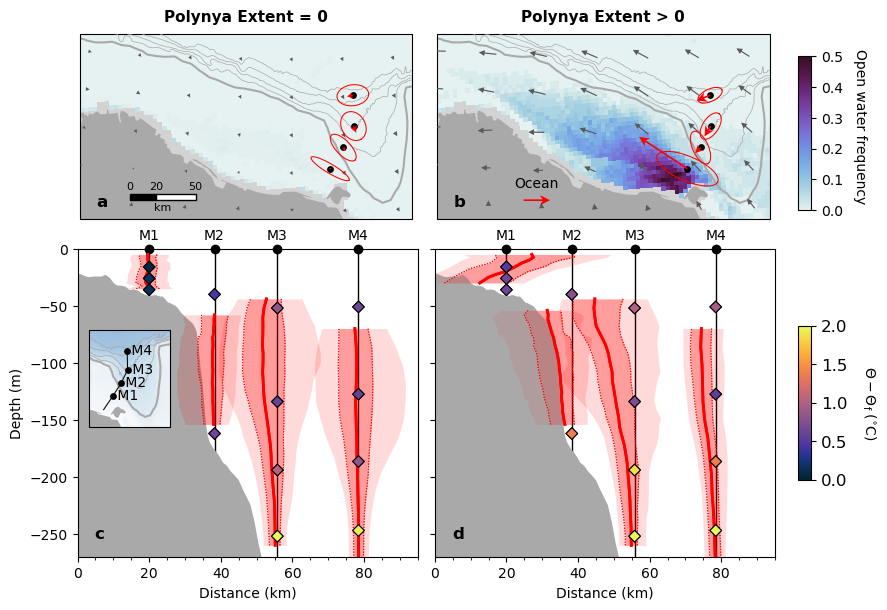

In [515]:
%matplotlib inline

# fig, ax = plt.subplots(figsize=(6,3.5))

fig, axs = plt.subplots(1,2,figsize=(9,4))

for ax in axs:
    kwargs = {'width' : 5, 'color':'gray', 'head_length':5, 'length_includes_head':True}
#     ax.axvline(distances[labels=='M1'], ls='dashed', c='k', lw=0.5)
    ax.set_xlabel('Distance (km)')
    
    # ax.set_xlim(0,145)
    # ax.set_ylim(-460,0)

    # yyy = -440
    # ax.arrow(135, yyy, -50, 0, **kwargs)
    # ax.text(110, yyy+20, 'Toward-shelf', ha='center', weight='bold', color='gray')

    # ax.arrow(75, yyy, -65, 0, **kwargs)
    # ax.text(40, yyy+20, 'Along-shelf', ha='center', weight='bold', color='gray')

    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(5))

    ax.set_xlim(0,95)
    ax.set_ylim(-270,0)
    
    
axs[0].set_ylabel('Depth (m)')
axs[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.05)





# plot the cross-shelf flow
#-------------------------

for ax in axs:
    ax.fill_between(distances, elevations, -600, color='darkgray')
#     ax.patch.set_facecolor([0.95,0.95,0.95])

    for x, y, t in zip(distances[show_labels], elevations[show_labels], labels[show_labels]):
        ax.scatter(x, 0, color='k', clip_on=False)
        ax.axvline(x, c='k', lw=1, zorder=-1)
        ax.text(x, 0+5, f'{t}', ha='center', va='bottom', color='k', clip_on=False)


        
    # do the plotting
    #-------------------------
    for ma in mdat.keys():
        
        X = distances[labels==ma]
        
        for ax, cond,  color, alpha in zip(axs, ['comp', 'open'], 
                                                  ['r', 'r'], 
                                                  [0.15,0.15]):

            # grab data
            depths = mdat[ma][cond]['depth']
            mn = mdat[ma][cond]['ctr']
            left = mdat[ma][cond]['lft']
            right = mdat[ma][cond]['rgt']
            left_m = mdat[ma][cond]['l_max']
            right_m = mdat[ma][cond]['r_max']

            ax.plot( scale * (mn) + X, depths, c=color, lw=2)

            ax.fill_betweenx(depths,
                             scale * (left) + X,
                             scale * (right) + X,  color=color, alpha=alpha, lw=0)

            ax.plot( scale * (left) + X, depths, c=color, lw=0.75, ls='dotted')
            ax.plot( scale * (right) + X, depths, c=color, lw=0.75, ls='dotted')

            ax.fill_betweenx(depths,
                             scale * (left_m) + X,
                             scale * (right_m) + X,  color=color, alpha=alpha*0.5, lw=0)

    
    
    for ma in mdat.keys():
        
        for ax, cond in zip(axs, ['comp', 'open'], ):
        
            X = distances[labels==ma]
            
            C = mdat[ma][cond]['Tmn']
            y = mdat[ma][cond]['T_depth']

            tmarker_kw = {'edgecolor':'k', 'lw':0.75, 's':35, 'marker':'D', 'zorder':100}
            cbi = ax.scatter(np.full(len(y), X),  y, c=C, 
                       vmin=0, vmax=2, cmap=cmocean.cm.thermal,  **tmarker_kw)

    
    
show_inset_map(axs[0])


# plot top-down views
#-------------------------------------------------------
BBOX = (-0.025, 1.075, 1, 1)

inax0 = show_inset_map2(axs[0], width="100%", height="60%", bbox_to_anchor=BBOX)
inax1 = show_inset_map2(axs[1], width="100%", height="60%", bbox_to_anchor=BBOX)


for ax, lab in zip(axs, ['c', 'd']):
    ax.text(0.05,0.05,lab, weight='bold',size=12, ha='left', va='bottom',clip_on=False, transform=ax.transAxes)
for ax, lab, key in zip([inax1, inax0], ['b', 'a'], ['open', 'comp']):
    ax.text(0.05,0.05,lab, weight='bold',size=12, ha='left', va='bottom',clip_on=False, transform=ax.transAxes)

    cmesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
                  vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])


    for m in ['M1', 'M2','M3', 'M4']:
        ax.scatter(M[m]['lon'], M[m]['lat'], c='k', s = 15, transform=ccrs.PlateCarree(), zorder=100)

ax=inax1
plotter.add_colorbar(fig, ax, [cmesh], cb_placement='right', cb_orientation='vertical', 
                     cb_width=0.015, cb_length_fraction=[0.875+0.25, 0.875+0.75], cb_pad=0.025, cb_ticks='auto', 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='', labelpad=30, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=plt.rcParams["font.size"], draw_edges=False, edge_params=['k', 2])
ax.text(1.25, 0.5, 'Open water frequency', rotation=-90, va='center', transform=ax.transAxes)


ax = axs[1]
plotter.add_colorbar(fig, ax, [cbi], cb_placement='right', cb_orientation='vertical', 
                     cb_width=0.015, cb_length_fraction=[0.25, 0.75], cb_pad=0.025, cb_ticks='auto', 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='', labelpad='auto', 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=12, draw_edges=False, edge_params=['k', 2])
ax.text(1.25, 0.5, '$\mathrm{\Theta-\Theta_f\;(^{\circ}C)}$', rotation=-90, va='center', transform=ax.transAxes)

aw = 0.005

for group, color, ax in zip(['comp','open'], ['r', 'r'], [inax0, inax1]):

#     sp = 1
#     key = group
#     u1 = 1*np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
#     v1 = 1*np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
#     Q = ax.quiver(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], u1[::sp,::sp], v1[::sp,::sp], 
#               angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
#               scale=1, width=0.0035, headwidth=5,headlength=5, headaxislength=5, 
#                   color=[0.35,0.35,0.35], pivot='tail', zorder=98)

    sp1, sp2 = 1,4
    key = group
    u1 = 0.02*wind_map[key]['u10']*units('m/s').to('m/day').magnitude
    v1 = 0.02*wind_map[key]['v10']*units('m/s').to('m/day').magnitude
    Q = ax.quiver(wind_map[key]['lon'][::sp1,::sp2], 
                  wind_map[key]['lat'][::sp1,::sp2], u1[::sp1,::sp2], v1[::sp1,::sp2], 
              angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
              scale=1, width=0.0035, headwidth=5,headlength=5, headaxislength=5, 
                  color=[0.35,0.35,0.35], pivot='tail', zorder=98)

    
    for m in ['M1', 'M2','M3', 'M4']:
        cdata = vecdata[m]['ocn'][group]

        SCALE = 1
        Qo = ax.quiver(cdata['tail_x'], cdata['tail_y'], 
                  cdata['mean_x'], cdata['mean_y'], 
                  angles='xy', scale_units='xy', scale=SCALE, color=color, width=aw, 
                  headwidth=6, headlength = 6, zorder=100)
        
        ax.plot((1/SCALE)*cdata['varell_x']+cdata['tail_x'], 
                (1/SCALE)*cdata['varell_y']+cdata['tail_y'], c=color, zorder=99, lw=0.75, alpha=1)

        
# qk = ax.quiverkey(Q, X=0.175, Y=0.1, U=20*1000, label='Ice', labelpos='N', coordinates='axes')
qk = ax.quiverkey(Qo, X=0.3, Y=0.1, U=20*1000, label='Ocean', labelpos='N', coordinates='axes')

#         cdata = vecdata[m]['ice'][group]

#         ax.quiver(cdata['tail_x'], cdata['tail_y'], 
#                   cdata['mean_x'], cdata['mean_y'], 
#                   angles='xy', scale_units='xy', scale=1, color=[0.3,0.3,0.3], width=aw, 
#                   headwidth=6, headlength = 6, zorder=100)

#         ax.plot(cdata['varell_x']+cdata['tail_x'], 
#                 cdata['varell_y']+cdata['tail_y'], c=[0.3,0.3,0.3], zorder=99, lw=0.5, alpha=1)


# fig.savefig('../figures/results/canyon_flow_v2.png', dpi=400, bbox_inches='tight', pad_inches=0)



# qk = inax1.quiverkey(Q, X=0.125, Y=0.1, U=15*1000, label='Ice', labelpos='N', coordinates='axes')
geomap.scalebar(inax0, loc=(0.15, 0.1), steps=[20,50],unit='km', 
                unit_label=None, colors=['k', 'w'], edgecolor=None, textsize=8, lw=1, 
                bar_width=0.035, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=True)

# fig.savefig('../figures/results/Fig08b.png', dpi=400, bbox_inches='tight', pad_inches=0)


# show reference orientation 
# for ax in [inax1, inax0]:
#     # dashed line
#     startlon, startlat = -139.1, 69.6
#     endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
#     ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
#             c=[0.3,0.3,0.3], lw=1.5, zorder=98, ls='dashed')

#     ax.add_geometries ([reg_poly], lw=3,alpha=0.25, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    


# ev_st = event_dates["open"][0].strftime("%Y.%m.%d")
# ev_fn = event_dates["open"][-1].strftime("%Y.%m.%d")



ax = inax0
ax.text(0.5,1.05,'Polynya Extent = 0', weight='bold',size=11, ha='center', va='bottom',clip_on=False, transform=ax.transAxes)

ax = inax1
ax.text(0.5,1.05,'Polynya Extent > 0', weight='bold',size=11, ha='center', va='bottom',clip_on=False, transform=ax.transAxes)


# ax = inax0
# ax.text(0.5,1.05,'Polynya Extent = 0', weight='bold',size=11, ha='center', va='bottom',clip_on=False, transform=ax.transAxes)

# ax = inax1
# ax.text(0.5,1.05,f'Polynya Extent > 0\n({ev_st} -- {ev_fn})', weight='bold',size=11, ha='center', va='bottom',clip_on=False, transform=ax.transAxes)


# fig.savefig(f'../figures/results/cross-shelf/cross_shelf_Event_{ev_st}-{ev_fn}.png', dpi=400, bbox_inches='tight', pad_inches=0)

# fig.savefig(f'../figures/results/cross-shelf/cross_shelf_version_Large_WithIce.png', dpi=400, bbox_inches='tight', pad_inches=0)

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:395: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:395: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


NameError: name 'formatter' is not defined

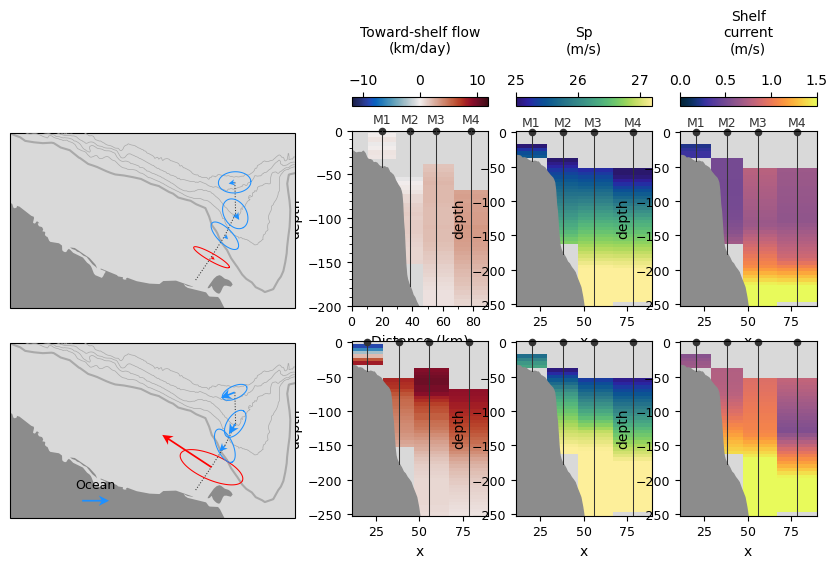

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:395: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:395: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)
/opt/an

Text(0, 1.1, 'MCP event')

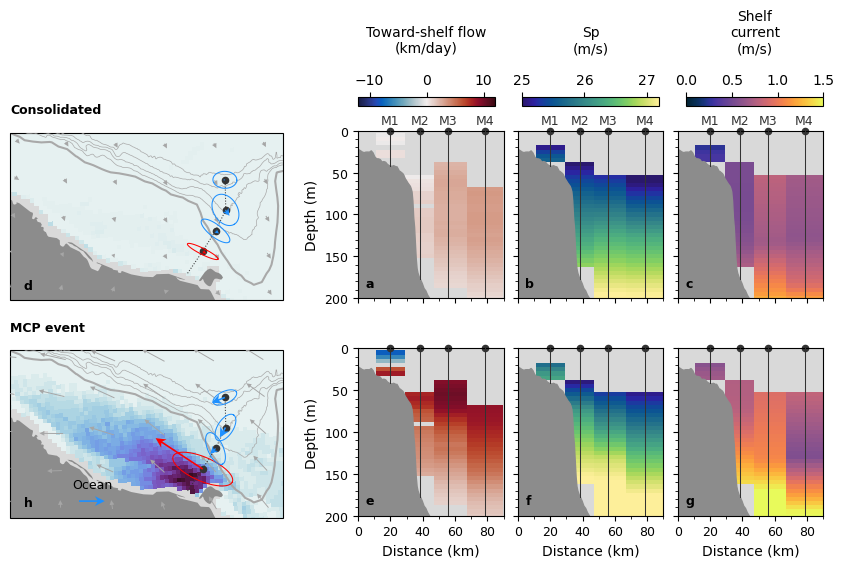

In [834]:
%matplotlib inline

# fig, ax = plt.subplots(figsize=(6,3.5))

fig, AXS = plt.subplots(2,3,figsize=(6,5))

axs = AXS.ravel()





moocolor = [0.2]*3



# plot the cross-shelf flow
#-------------------------

for ax in axs:
    ax.patch.set_facecolor([0.85]*3)
    ax.fill_between(distances, elevations, -600, color=[0.55]*3)

    for x, y, t in zip(distances[show_labels], elevations[show_labels], labels[show_labels]):
        ax.scatter(x, 0, color=moocolor, s=20, clip_on=False)
        ax.plot([x,x], [y,0], c=moocolor, lw=0.75,ls='solid', zorder=100)
        if ax in [axs[0], axs[1], axs[2]]:
            ax.text(x, 0+5, f'{t}', ha='center', va='bottom', color=moocolor, clip_on=False)
    
    
# ((mdst.Sp).sel(time=comp_hours).mean('time')).plot(ax = axs[1], add_colorbar=False,
#                                                            x='x', vmin=31.5,vmax=34, cmap=cmocean.cm.haline, zorder=-1)
# ((mdst.Sp).sel(time=open_hours).mean('time')).plot(ax = axs[4], add_colorbar=False,
#                                                            x='x', vmin=31.5,vmax=34, cmap=cmocean.cm.haline, zorder=-1)



((mdsc.cross*units('m/s').to('km/day')).sel(time=comp_hours).mean('time')).plot(ax = axs[0], add_colorbar=False,
                                                           x='x', vmin=-12,vmax=12, cmap=cmocean.cm.balance, zorder=-1)
meshC = ((mdsc.cross*units('m/s').to('km/day')).sel(time=open_hours).mean('time')).plot(ax = axs[3], add_colorbar=False,
                                                           x='x', vmin=-12,vmax=12, cmap=cmocean.cm.balance, zorder=-1)

plotter.add_colorbar(fig, axs[0], [meshC], cb_placement='top', cb_orientation='auto',
                     cb_width='auto', cb_length_fraction=[0, 1], cb_pad=0.05, cb_ticks='auto', 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Toward-shelf flow\n(km/day)',#'Days\nfrom\nDec. 1',
                     labelpad=15, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=10, draw_edges=False, edge_params=['k', 2])


((mdst.sig0).sel(time=comp_hours).mean('time')).plot(ax = axs[1], add_colorbar=False,
                                                           x='x', vmin=25,vmax=27.2, cmap=cmocean.cm.haline, zorder=-1)
meshS = ((mdst.sig0).sel(time=open_hours).mean('time')).plot(ax = axs[4], add_colorbar=False,
                                                           x='x', vmin=25,vmax=27.2, cmap=cmocean.cm.haline, zorder=-1)

# ((mdst.Sp).sel(time=comp_hours).mean('time')).plot(ax = axs[1], add_colorbar=False,
#                                                            x='x', vmin=31,vmax=34, cmap=cmocean.cm.haline, zorder=-1)
# meshS = ((mdst.Sp).sel(time=open_hours).mean('time')).plot(ax = axs[4], add_colorbar=False,
#                                                            x='x', vmin=31,vmax=34, cmap=cmocean.cm.haline, zorder=-1)

plotter.add_colorbar(fig, axs[1], [meshS], cb_placement='top', cb_orientation='auto',
                     cb_width='auto', cb_length_fraction=[0, 1], cb_pad=0.05, cb_ticks='auto', 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Sp\n(m/s)',#'Days\nfrom\nDec. 1',
                     labelpad=15, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=10, draw_edges=False, edge_params=['k', 2])
    
((mdst.Ct-mdst.Tf).sel(time=comp_hours).mean('time')).plot(ax = axs[2], add_colorbar=False,
                                                           x='x', vmin=0,vmax=1.5, cmap=cmocean.cm.thermal, zorder=-1)
meshT = ((mdst.Ct-mdst.Tf).sel(time=open_hours).mean('time')).plot(ax = axs[5], add_colorbar=False,
                                                           x='x', vmin=0,vmax=1.5, cmap=cmocean.cm.thermal, zorder=-1)


plotter.add_colorbar(fig, axs[2], [meshT], cb_placement='top', cb_orientation='auto',
                     cb_width='auto', cb_length_fraction=[0, 1], cb_pad=0.05, cb_ticks='auto', 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Shelf\ncurrent\n(m/s)',#'Days\nfrom\nDec. 1',
                     labelpad=15, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=10, draw_edges=False, edge_params=['k', 2])


# (((mdst.sig0)*(mdst.Ct-mdst.Tf)).sel(time=comp_hours).mean('time')).plot(ax = axs[2], add_colorbar=False,
#                                                            x='x', vmin=0,vmax=50, cmap=cmocean.cm.thermal, zorder=-1)
# (((mdst.sig0)*(mdst.Ct-mdst.Tf)).sel(time=open_hours).mean('time')).plot(ax = axs[5], add_colorbar=False,
#                                                            x='x', vmin=0,vmax=50, cmap=cmocean.cm.thermal, zorder=-1)




# show_inset_map(axs[0])

# plot top-down views
#-------------------------------------------------------
BBOX = (-2.75, -0.05, 1, 1)

inax0 = show_inset_map2(axs[0],  width="250%",height="100%", bbox_to_anchor=BBOX)
inax1 = show_inset_map2(axs[3], width="250%",height="100%", bbox_to_anchor=BBOX)


aw = 0.006

for group, color, ax in zip(['comp','open'], ['r', 'r'], [inax0, inax1]):

#     sp = 1
#     key = group
#     u1 = 1*np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
#     v1 = 1*np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
#     Q = ax.quiver(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], u1[::sp,::sp], v1[::sp,::sp], 
#               angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
#               scale=1, width=0.0035, headwidth=5,headlength=5, headaxislength=5, 
#                   color=[0.35,0.35,0.35], pivot='tail', zorder=98)

    sp1, sp2 = 1,4
    key = group
    u1 = 0.03*wind_map[key]['u10']*units('m/s').to('m/day').magnitude
    v1 = 0.03*wind_map[key]['v10']*units('m/s').to('m/day').magnitude
    Q = ax.quiver(wind_map[key]['lon'][::sp1,::sp2], 
                  wind_map[key]['lat'][::sp1,::sp2], u1[::sp1,::sp2], v1[::sp1,::sp2], 
              angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
              scale=1, width=0.0035, headwidth=5,headlength=5, headaxislength=5, 
                  color=[0.65]*3, pivot='tail', zorder=5)

    
    for m, color in zip(['M1', 'M2','M3', 'M4'], ['r', 'dodgerblue', 'dodgerblue', 'dodgerblue']):
        cdata = vecdata[m]['ocn'][group]

        SCALE = 1
        Qo = ax.quiver(cdata['tail_x'], cdata['tail_y'], 
                  cdata['mean_x'], cdata['mean_y'], 
                  angles='xy', scale_units='xy', scale=SCALE, color=color, width=aw, 
                  headwidth=6, headlength = 6, zorder=100)
        
        ax.plot((1/SCALE)*cdata['varell_x']+cdata['tail_x'], 
                (1/SCALE)*cdata['varell_y']+cdata['tail_y'], c=color, zorder=99, lw=0.75, alpha=1)
        
    for m in ['M0','M1', 'M2','M3', ]: 
        ax.plot([M[m]['lon'], M[f'M{int(m[1])+1}']['lon']], 
                   [M[m]['lat'], M[f'M{int(m[1])+1}']['lat']],  c=moocolor, 
                   lw=0.75, ls='dotted', transform=ccrs.PlateCarree(), zorder=98)

        
# qk = ax.quiverkey(Q, X=0.175, Y=0.1, U=20*1000, label='Ice', labelpos='N', coordinates='axes')
qk = ax.quiverkey(Qo, X=0.3, Y=0.1, U=20*1000, label='Ocean', labelpos='N', coordinates='axes')



for ax in axs:
    kwargs = {'width' : 5, 'color':'gray', 'head_length':5, 'length_includes_head':True}
#     ax.axvline(distances[labels=='M1'], ls='dashed', c='k', lw=0.5)
    ax.set_xlabel('Distance (km)')
    
    # ax.set_xlim(0,145)
    # ax.set_ylim(-460,0)

    # yyy = -440
    # ax.arrow(135, yyy, -50, 0, **kwargs)
    # ax.text(110, yyy+20, 'Toward-shelf', ha='center', weight='bold', color='gray')

    # ax.arrow(75, yyy, -65, 0, **kwargs)
    # ax.text(40, yyy+20, 'Along-shelf', ha='center', weight='bold', color='gray')

    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ax.yaxis.set_minor_locator(MultipleLocator(10))

    ax.set_xlim(0,90)
    ax.set_ylim(-200,0)
    
    ax.yaxis.set_major_formatter(formatter)  # convert depth to positive values
    
    
for ax in [axs[1],axs[2],axs[4], axs[5]]:
    ax.set_yticklabels([])
    ax.set_ylabel("")
    
for ax in [axs[0],axs[1],axs[2]]:
    ax.set_xticklabels([])
    ax.set_xlabel("")
    
for ax in [axs[0],axs[3]]:
    ax.set_ylabel('Depth (m)')
    
    
for ax, lab in zip(axs, ['a', 'b', 'c', 'e', 'f', 'g']):
    ax.text(0.05,0.05,lab, weight='bold', ha='left', va='bottom',clip_on=False, transform=ax.transAxes)
for ax, lab, key in zip([inax0, inax1], ['d', 'h'], [ 'comp', 'open']):
    ax.text(0.05,0.05,lab, weight='bold', ha='left', va='bottom',clip_on=False, transform=ax.transAxes)

    cmesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
                  vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])

#     cmesh = ax.contourf(map_sic[key]['xx'], map_sic[key]['yy'], 100*map_sic[key]['open_freq'], 
#                   vmin=0, vmax=50, levels=np.arange(0,50,2.5), cmap=cmocean.cm.dense, transform=dsic['proj'])


    for m in ['M1', 'M2','M3', 'M4']:
        ax.scatter(M[m]['lon'], M[m]['lat'], c=moocolor, s = 20, transform=ccrs.PlateCarree(), zorder=95)
        
        
    
# axs[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.1, hspace=0.3)




ax = inax0
ax.text(0,1.1,'Consolidated', weight='bold', ha='left', va='bottom',clip_on=False, transform=ax.transAxes)

ax = inax1
ax.text(0,1.1,'MCP event', weight='bold', ha='left', va='bottom',clip_on=False, transform=ax.transAxes)


# SAVE(fig, "/Users/mackenziejewell/Desktop/Fig12.png")

In [685]:
285 - 90

195

In [677]:
145+90

235

In [660]:
help(plotter.colorbar)

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


AttributeError: module 'plot_simply.general' has no attribute 'colorbar'

## Look at properties of water over the shelf

In [444]:
year = 2019


dss = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_{year-1}_{year}.nc')
dt = ((pd.to_datetime(dss.time) - datetime(year-1, 12, 1))).days

new_var_dataarray = xr.DataArray(dt, coords={"time": dss.time}, dims=["time"])

# Assign the new DataArray as a new variable to the Dataset
dss = dss.assign(dt=new_var_dataarray)


DS = dss.sel(depth=dss.depth.min())

DS = dss.sel(depth = -16)


DEPTH = int(DS.depth.values.item())

# open and compact dates for years
cond = ((df.extent>0)&(df.year==year)) #& ((df.final_day==False)&(df.first_day==False))
polynya_times = pd.to_datetime(df.time[cond].values)

cond = ((df.extent==0)&(df.year==year))#&(df.after_event_length>1)
compact_times = pd.to_datetime(df.time[cond].values)

# hourly polynya open times
ptimes = np.array([], dtype=np.datetime64)
for time in polynya_times:
    for hour in np.arange(24):
        ptimes = np.append(ptimes, time+timedelta(hours=int(hour)))
        
# hourly compact times
ctimes = np.array([], dtype=np.datetime64)
for time in compact_times:
    for hour in np.arange(24):
        ctimes = np.append(ctimes, time+timedelta(hours=int(hour)))

In [440]:
dso = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_{year-1}_{year}.nc')
ESE = vectors.comp_along_theta(dso.u.mean('depth'), dso.v.mean('depth'), -145*units('degree'))

# colormap to show current strength
cmap = cmocean.cm.balance
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

# colormap for day of year
# cmap = cmocean.cm.haline
# norm = matplotlib.colors.Normalize(vmin=0, vmax=150)


<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_15682/1041574474.py:29: SyntaxWarning: invalid escape sequence '\m'
  axs[0].set_ylabel('Ct ($\mathrm{^{\circ}C}$)', rotation=0, labelpad=20)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_15682/1041574474.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(DS.Sp.sel(time=ptimes), DS.Ct.sel(time=ptimes), s=20,


(<matplotlib.colorbar.Colorbar at 0x165098860>,
 <Axes: ylabel='Shelf\ncurrent\n(m/s)'>)

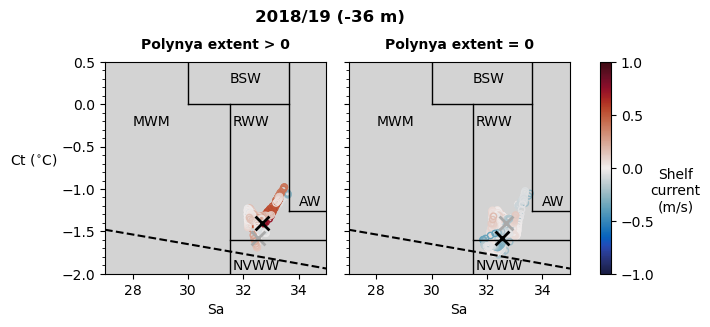

In [441]:
fig, axs = plt.subplots(1,2,figsize=(6,2.75))

for ax in axs:
    ax.patch.set_facecolor('lightgray')
    ax.set_xlim(27,35)
    ax.set_ylim(-2,0.5)
    ax.text(31.5, 0.25, 'BSW', weight='normal')
    ax.text(31.6, -0.25, 'RWW', weight='normal')
    ax.text(34, -1.2, 'AW', weight='normal')
    ax.text(28, -0.25, 'MWM', weight='normal')
    ax.text(31.6, -1.95, 'NVWW', weight='normal')
    ax.plot([31.5, 31.5], [-2,0], c='k', lw=1)
    ax.plot([31.5,35], [-1.6,-1.6], c='k', lw=1)
    ax.plot([33.64,33.64], [-1.26,0.5], c='k', lw=1)
    ax.plot([33.64,35], [-1.26,-1.26], c='k', lw=1)
    ax.plot([30,33.64], [0,0], c='k', lw=1)
    ax.plot([30,30], [0,0.5], c='k', lw=1)
    ax.plot(Sf_line, Tf_line, c='k', ls='dashed')
    
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    
    ax.set_xlabel('Sa')
    
plt.subplots_adjust(wspace=0.1)
plt.suptitle(f'{year-1}/{str(year)[2:]} ({DEPTH} m)', weight='bold', y = 1.07)


axs[0].set_ylabel('Ct ($\mathrm{^{\circ}C}$)', rotation=0, labelpad=20)
axs[0].text(0.5, 1.05, 'Polynya extent > 0',weight='bold', ha='center', va='bottom', transform=axs[0].transAxes)
axs[1].set_yticklabels([])
axs[1].text(0.5, 1.05, 'Polynya extent = 0', weight='bold',ha='center', va='bottom', transform=axs[1].transAxes)
    
ax = axs[0]
# ax.scatter(DS.Sp.sel(time=ptimes), DS.Ct.sel(time=ptimes), s=20,
#            edgecolors=cmap(norm(ESE.sel(time=ptimes))), facecolors='None', vmin=-1,vmax=1, cmap=cmocean.cm.balance)

ax.scatter(DS.Sp.sel(time=ptimes), DS.Ct.sel(time=ptimes), s=20,
           edgecolors=cmap(norm(ESE.sel(time=ptimes))), facecolors='None', vmin=-1,vmax=1)
#            edgecolors=cmap(norm(DS.dt.sel(time=ptimes))), facecolors='None')
ax.scatter(DS.Sp.sel(time=ctimes).mean(), DS.Ct.sel(time=ctimes).mean(),  c='darkgray', lw=2, marker='x', s=100)
ax.scatter(DS.Sp.sel(time=ptimes).mean(), DS.Ct.sel(time=ptimes).mean(), c='k', lw=2, marker='x', s=100)

ax = axs[1]
ax.scatter(DS.Sp.sel(time=ctimes), DS.Ct.sel(time=ctimes), s=20,
           edgecolors=cmap(norm(ESE.sel(time=ctimes))), facecolors='None')
#            edgecolors=cmap(norm(DS.dt.sel(time=ctimes))), facecolors='None')
ax.scatter(DS.Sp.sel(time=ptimes).mean(), DS.Ct.sel(time=ptimes).mean(), c='darkgray', lw=2, marker='x', s=100)
ax.scatter(DS.Sp.sel(time=ctimes).mean(), DS.Ct.sel(time=ctimes).mean(),  c='k', lw=2, marker='x', s=100)


plotter.add_colorbar(fig, ax, [cmap, norm], cb_placement='right', cb_orientation='auto',
                     cb_width='auto', cb_length_fraction=[0, 1], cb_pad=0.05, cb_ticks='auto', 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Shelf\ncurrent\n(m/s)',#'Days\nfrom\nDec. 1',
                     labelpad=15, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=10, draw_edges=False, edge_params=['k', 2])

# fig.savefig(f'../figures/mooring_relations/M1_properties_curr_{year}_depth{DEPTH}.png', dpi=400, bbox_inches='tight', pad_inches=0)


<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_15682/3285085828.py:29: SyntaxWarning: invalid escape sequence '\m'
  axs[0].set_ylabel('Ct ($\mathrm{^{\circ}C}$)', rotation=0, labelpad=20)


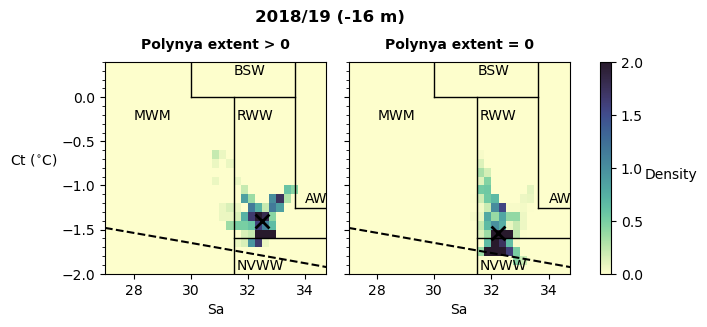

In [445]:
fig, axs = plt.subplots(1,2,figsize=(6,2.75))

for ax in axs:
    ax.patch.set_facecolor('lightgray')
    ax.set_xlim(27,35)
    ax.set_ylim(-2,0.5)
    ax.text(31.5, 0.25, 'BSW', weight='normal')
    ax.text(31.6, -0.25, 'RWW', weight='normal')
    ax.text(34, -1.2, 'AW', weight='normal')
    ax.text(28, -0.25, 'MWM', weight='normal')
    ax.text(31.6, -1.95, 'NVWW', weight='normal')
    ax.plot([31.5, 31.5], [-2,0], c='k', lw=1)
    ax.plot([31.5,35], [-1.6,-1.6], c='k', lw=1)
    ax.plot([33.64,33.64], [-1.26,0.5], c='k', lw=1)
    ax.plot([33.64,35], [-1.26,-1.26], c='k', lw=1)
    ax.plot([30,33.64], [0,0], c='k', lw=1)
    ax.plot([30,30], [0,0.5], c='k', lw=1)
    ax.plot(Sf_line, Tf_line, c='k', ls='dashed')
    
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    
    ax.set_xlabel('Sa')
    
plt.subplots_adjust(wspace=0.1)
plt.suptitle(f'{year-1}/{str(year)[2:]} ({DEPTH} m)', weight='bold', y = 1.07)


axs[0].set_ylabel('Ct ($\mathrm{^{\circ}C}$)', rotation=0, labelpad=20)
axs[0].text(0.5, 1.05, 'Polynya extent > 0',weight='bold', ha='center', va='bottom', transform=axs[0].transAxes)
axs[1].set_yticklabels([])
axs[1].text(0.5, 1.05, 'Polynya extent = 0', weight='bold',ha='center', va='bottom', transform=axs[1].transAxes)
    
    
    
x_bins = np.arange(27,35,0.25)
y_bins = np.arange(-2,0.5,0.1)


cmap = cmocean.cm.deep
norm = matplotlib.colors.Normalize(vmin=0, vmax=2)


# Create the 2D histogram
ax = axs[0]
ax.hist2d(DS.Sp.sel(time=ptimes), DS.Ct.sel(time=ptimes), bins=[x_bins, y_bins], cmap=cmap, norm=norm, density=True);
ax.scatter(DS.Sp.sel(time=ptimes).mean(), DS.Ct.sel(time=ptimes).mean(), c='k', lw=2, marker='x', s=100)

# x = DS.Sp.sel(time=ptimes).values
# y = DS.Ct.sel(time=ptimes).values
# xp = x[np.isfinite(x)&np.isfinite(y)]
# yp = y[np.isfinite(x)&np.isfinite(y)]
# varell = tanalyze.variance_ellipses(xp,yp)
# ax.plot(varell['xe']+np.mean(xp),  varell['ye']+np.mean(yp), c='k', zorder=99, lw=1.5, alpha=1)


ax = axs[1]
ax.hist2d(DS.Sp.sel(time=ctimes), DS.Ct.sel(time=ctimes), bins=[x_bins, y_bins], cmap=cmap, norm=norm, density=True);
ax.scatter(DS.Sp.sel(time=ctimes).mean(), DS.Ct.sel(time=ctimes).mean(),  c='k', lw=2, marker='x', s=100)


# x = DS.Sp.sel(time=ctimes).values
# y = DS.Ct.sel(time=ctimes).values
# xp = x[np.isfinite(x)&np.isfinite(y)]
# yp = y[np.isfinite(x)&np.isfinite(y)]
# varell = tanalyze.variance_ellipses(xp,yp)
# ax.plot(varell['xe']+np.mean(xp),  varell['ye']+np.mean(yp), c='k', zorder=99, lw=1.5, alpha=1)

plotter.add_colorbar(fig, ax, [cmap,norm], cb_placement='right', cb_orientation='auto',
                     cb_width='auto', cb_length_fraction=[0, 1], cb_pad=0.05, cb_ticks='auto', 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Density',
                     labelpad=20, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=10, draw_edges=False, edge_params=['k', 2])

fig.savefig(f'../figures/mooring_relations/M1_properties_freq_{year}_depth{DEPTH}.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [412]:
DS.Sp.sel(time=ptimes).values

array([32.51963238, 32.5252664 , 32.52996087, 32.53214649, 32.5304545 ,
       32.52610329, 32.52002552, 32.5143498 , 32.51048141, 32.50762511,
       32.50424701, 32.50063583, 32.49844252, 32.49783529, 32.49987799,
       32.50316918, 32.50372478, 32.50098922, 32.49637649, 32.48880117,
       32.47708026, 32.46235848, 32.44402915, 32.4175328 , 32.38469912,
       32.35569966, 32.32468768, 32.30425633, 32.32244709, 32.34949275,
       32.35043338, 32.33497796, 32.32951044, 32.3542139 , 32.38243623,
       32.39685367, 32.43995623, 32.49962888, 32.54026026, 32.55760427,
       32.60651617, 32.703119  , 32.76310888, 32.76642315, 32.80768166,
       32.92848757, 33.01097596, 33.03628466, 33.0630834 , 33.04194128,
       33.02438937, 33.08831608, 33.12839374, 33.09103662, 33.08726462,
       33.10481515, 33.12945222, 33.19181727, 33.21964022, 33.24198973,
       33.30983696, 33.39121155, 33.43767291, 33.46343176, 33.49847968,
       33.53243144, 33.57119417, 33.60752848, 33.6171075 , 33.61

In [231]:
dt

Index([-61, -61, -61, -61, -61, -61, -61, -61, -61, -61,
       ...
       303, 303, 303, 303, 303, 303, 303, 303, 303, 304],
      dtype='int64', length=8761)

In [91]:
import gsw
import gsw.freezing

In [94]:
# sea pressure ( i.e. absolute pressure - 10.1325 dbar )
p = gsw.conversions.p_from_z(DS.depth.values[0], DS.attrs['lat'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
saturation_fraction = 1
Sf_line = np.linspace(27, 35)
Tf_line = gsw.freezing.CT_freezing(Sf_line, p, saturation_fraction)